# Waste Classification Project using a complete CNN from scratch with a pipeline of Preprocessing and Image Enhancement => Segmentation => Feature Extraction => Classification => Evaluation and Performance Metrics.

In [1]:
!python3 prepare_dataset.py

Preparing waste classification dataset from: /home/x/Desktop/dataset/
Found 6 classes: Clothes, Glass, Metal, Organic, Paper, Plastic
  Class Clothes: 500 default images, 500 real-world images
  Class Glass: 750 default images, 750 real-world images
  Class Metal: 1000 default images, 1000 real-world images
  Class Organic: 1000 default images, 1000 real-world images
  Class Paper: 1250 default images, 1250 real-world images
  Class Plastic: 2250 default images, 2250 real-world images

Dataset split complete:
  Training: 9450 images
  Validation: 2025 images
  Test: 2025 images
Dataset files written to ./labels


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from sklearn.utils import shuffle
import time
import gc  # Garbage collector for memory management
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Pipeline
from utils import load_dataset, visualize_results, save_model, ModelEvaluator
from preprocessing import ImagePreprocessor
from feature_extraction import FeatureExtractor
from classification import CustomClassifier

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

np.random.seed(42)
tf.random.set_seed(42)


In [6]:
print("devices:", tf.config.list_physical_devices())
print("Is GPU available:", tf.config.list_physical_devices('GPU'))
print("Using CPU for computation")

print("Starting Waste Classification Project Pipeline:")
print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime())}")

print("\n[1] Loading dataset...")
dataset_path = "/home/x/Desktop/dataset/"
dataset = load_dataset(dataset_path)

if dataset is None:
    print("Error loading dataset. Exiting.")
    raise ValueError("Dataset could not be loaded")

categories = dataset['categories']
print(f"Categories: {categories}")
print(f"Number of training samples: {len(dataset['train_data'])}")
print(f"Number of validation samples: {len(dataset['val_data'])}")
print(f"Number of test samples: {len(dataset['test_data'])}")

devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Is GPU available: []
Using CPU for computation
Starting Waste Classification Project Pipeline:
Current time: 2025-05-06 00:49:00

[1] Loading dataset...
Categories: ['Clothes', 'Glass', 'Metal', 'Organic', 'Paper', 'Plastic']
Number of training samples: 9450
Number of validation samples: 2025
Number of test samples: 2025



Training class distribution:
  Class Clothes: 700 samples (7.4%)
  Class Glass: 1050 samples (11.1%)
  Class Metal: 1400 samples (14.8%)
  Class Organic: 1400 samples (14.8%)
  Class Paper: 1750 samples (18.5%)
  Class Plastic: 3150 samples (33.3%)

Validation class distribution:
  Class Clothes: 150 samples (7.4%)
  Class Glass: 225 samples (11.1%)
  Class Metal: 300 samples (14.8%)
  Class Organic: 300 samples (14.8%)
  Class Paper: 375 samples (18.5%)
  Class Plastic: 675 samples (33.3%)

Test class distribution:
  Class Clothes: 150 samples (7.4%)
  Class Glass: 225 samples (11.1%)
  Class Metal: 300 samples (14.8%)
  Class Organic: 300 samples (14.8%)
  Class Paper: 375 samples (18.5%)
  Class Plastic: 675 samples (33.3%)

Final dataset sizes:
  Training: 9450 samples
  Validation: 2025 samples
  Test: 2025 samples


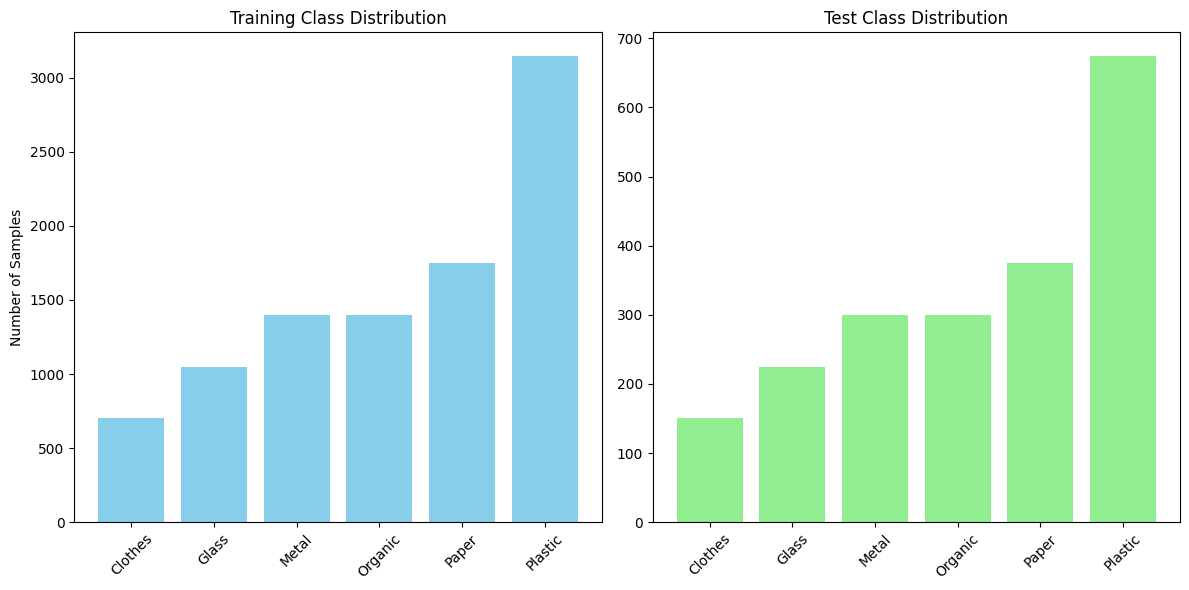


Starting preprocessing with material-specific augmentations...


In [7]:
def analyze_class_distribution(labels, name, categories):
    counts = np.zeros(len(categories), dtype=int)
    for label in labels:
        counts[label] += 1
    
    print(f"\n{name} class distribution:")
    for i, count in enumerate(counts):
        print(f"  Class {categories[i]}: {count} samples ({count/len(labels)*100:.1f}%)")
    return counts

train_counts = analyze_class_distribution(dataset['train_labels'], "Training", categories)
val_counts = analyze_class_distribution(dataset['val_labels'], "Validation", categories)
test_counts = analyze_class_distribution(dataset['test_labels'], "Test", categories)

train_data = dataset['train_data']
train_labels = dataset['train_labels']
val_data = dataset['val_data']
val_labels = dataset['val_labels']
test_data = dataset['test_data']
test_labels = dataset['test_labels']

print(f"\nFinal dataset sizes:")
print(f"  Training: {len(train_data)} samples")
print(f"  Validation: {len(val_data)} samples")
print(f"  Test: {len(test_data)} samples")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(categories, train_counts, color='skyblue')
plt.title('Training Class Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Samples')

plt.subplot(1, 2, 2)
plt.bar(categories, test_counts, color='lightgreen')
plt.title('Test Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nWarning: Processing the full dataset on CPU may take a significant amount of time.")
print("Starting preprocessing with material-specific augmentations...")


[2] Applying enhanced preprocessing...


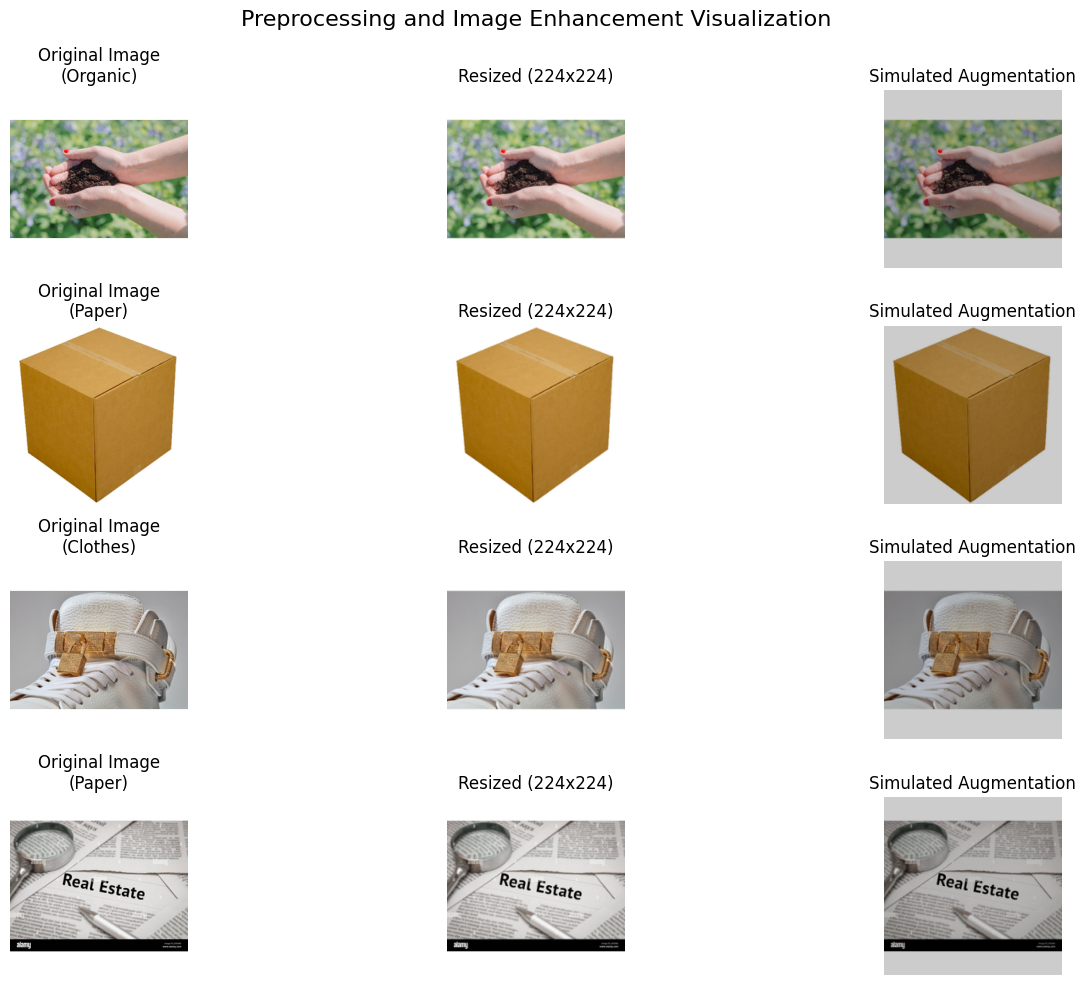

In [10]:
print("\n[2] Applying enhanced preprocessing...")

preprocessor = ImagePreprocessor(
    target_size=(224, 224), 
    apply_augmentation=True
)

batch_size = 1500

def process_in_batches(data_list, with_augmentation=False, desc="Processing"):
    preprocessor.apply_augmentation = with_augmentation
    all_processed = []
    
    for i in range(0, len(data_list), batch_size):
        batch_end = min(i + batch_size, len(data_list))
        batch = data_list[i:batch_end]
        
        print(f"Processing batch {i//batch_size + 1}/{(len(data_list)-1)//batch_size + 1} ({i}:{batch_end})")
        processed_batch = preprocessor.batch_preprocess(batch, segment=False)
        all_processed.extend(processed_batch)
        
        gc.collect()
    
    return all_processed

plt.figure(figsize=(15, 10))
plt.suptitle("Preprocessing and Image Enhancement Visualization", fontsize=16)

if len(train_data) > 0 and isinstance(train_data[0], str):
    num_examples = min(4, len(train_data))
    example_indices = np.random.choice(len(train_data), num_examples, replace=False)
    
    for i, idx in enumerate(example_indices):
        img_path = train_data[idx]
        try:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                plt.subplot(num_examples, 3, i*3+1)
                plt.imshow(img)
                plt.title(f"Original Image\n({categories[train_labels[idx]]})")
                plt.axis('off')
                
                resized = cv2.resize(img, (224, 224))
                plt.subplot(num_examples, 3, i*3+2)
                plt.imshow(resized)
                plt.title("Resized (224x224)")
                plt.axis('off')
                
                augmented = resized.copy()
                hsv = cv2.cvtColor(augmented, cv2.COLOR_RGB2HSV)
                hsv[:,:,2] = hsv[:,:,2] * 0.8
                augmented = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
                
                plt.subplot(num_examples, 3, i*3+3)
                plt.imshow(augmented)
                plt.title("Simulated Augmentation")
                plt.axis('off')
        except Exception as e:
            print(f"Error processing visualization for image {img_path}: {str(e)}")
else:
    plt.text(0.5, 0.5, "Cannot visualize preprocessing - data not in expected format", 
             ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Processing batch 1/7 (0:1500)


Preprocessing images: 100%|████████████████| 1500/1500 [00:06<00:00, 249.47it/s]


Processing batch 2/7 (1500:3000)


Preprocessing images: 100%|████████████████| 1500/1500 [00:06<00:00, 249.05it/s]


Processing batch 3/7 (3000:4500)


Preprocessing images: 100%|████████████████| 1500/1500 [00:06<00:00, 243.27it/s]


Processing batch 4/7 (4500:6000)


Preprocessing images: 100%|████████████████| 1500/1500 [00:05<00:00, 255.04it/s]


Processing batch 5/7 (6000:7500)


Preprocessing images: 100%|████████████████| 1500/1500 [00:05<00:00, 250.50it/s]


Processing batch 6/7 (7500:9000)


Preprocessing images: 100%|████████████████| 1500/1500 [00:06<00:00, 246.17it/s]


Processing batch 7/7 (9000:9450)


Preprocessing images: 100%|██████████████████| 450/450 [00:01<00:00, 249.75it/s]


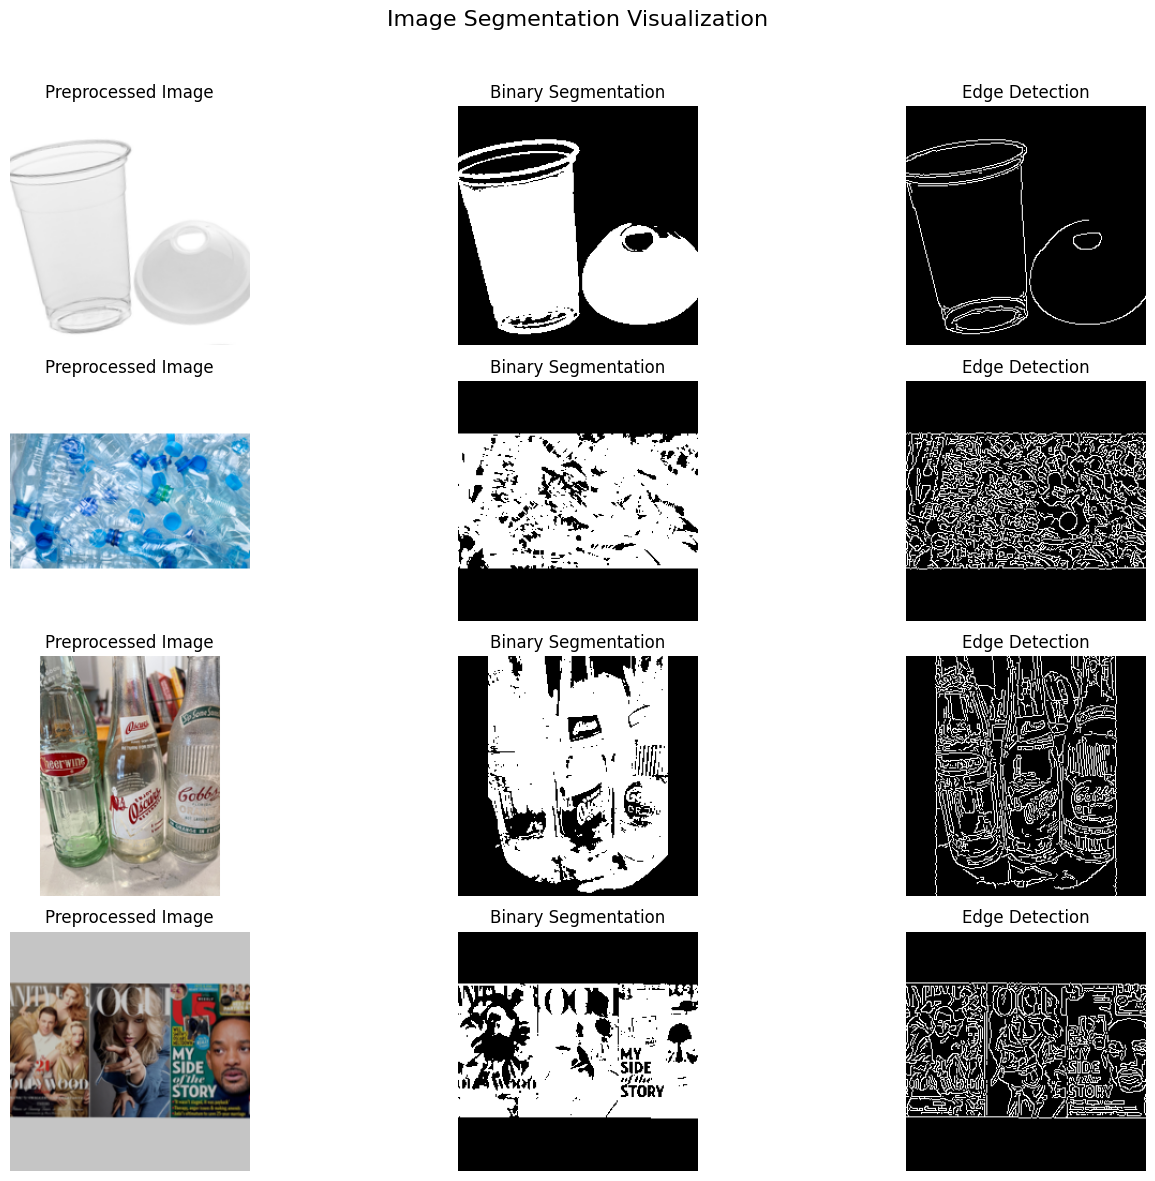

In [12]:
X_train_preprocessed = process_in_batches(train_data, with_augmentation=True, desc="Preprocessing training images")

if len(X_train_preprocessed) > 0:
    plt.figure(figsize=(15, 12))
    plt.suptitle("Image Segmentation Visualization", fontsize=16)
    
    num_examples = min(4, len(X_train_preprocessed))
    for i in range(num_examples):
        img = X_train_preprocessed[i]
        
        plt.subplot(num_examples, 3, i*3+1)
        plt.imshow(img)
        plt.title(f"Preprocessed Image")
        plt.axis('off')
        
        try:
            gray = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
            _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
            plt.subplot(num_examples, 3, i*3+2)
            plt.imshow(thresh, cmap='gray')
            plt.title("Binary Segmentation")
            plt.axis('off')
            
            edges = cv2.Canny(gray, 50, 150)
            plt.subplot(num_examples, 3, i*3+3)
            plt.imshow(edges, cmap='gray')
            plt.title("Edge Detection")
            plt.axis('off')
        except Exception as e:
            print(f"Error in segmentation visualization: {e}")
            plt.subplot(num_examples, 3, i*3+2)
            plt.text(0.5, 0.5, "Segmentation error", ha='center', va='center')
            plt.axis('off')
            plt.subplot(num_examples, 3, i*3+3)
            plt.text(0.5, 0.5, "Edge detection error", ha='center', va='center')
            plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [13]:
X_val_preprocessed = process_in_batches(val_data, with_augmentation=False, desc="Preprocessing validation images")
X_test_preprocessed = process_in_batches(test_data, with_augmentation=False, desc="Preprocessing test images")

Processing batch 1/2 (0:1500)


Preprocessing images: 100%|████████████████| 1500/1500 [00:02<00:00, 560.30it/s]


Processing batch 2/2 (1500:2025)


Preprocessing images: 100%|██████████████████| 525/525 [00:00<00:00, 554.20it/s]


Processing batch 1/2 (0:1500)


Preprocessing images: 100%|████████████████| 1500/1500 [00:02<00:00, 556.04it/s]


Processing batch 2/2 (1500:2025)


Preprocessing images: 100%|██████████████████| 525/525 [00:00<00:00, 552.93it/s]


In [14]:
print("\n[3] Extracting features...")

feature_extractor = FeatureExtractor(input_shape=(224, 224, 3))

def extract_features_in_batches(images, batch_size=4, desc="Extracting features"):
    all_features = []
    
    for i in range(0, len(images), batch_size):
        batch_end = min(i + batch_size, len(images))
        batch = images[i:batch_end]
        
        print(f"Extracting features batch {i//batch_size + 1}/{(len(images)-1)//batch_size + 1} ({i}:{batch_end})")
        try:
            batch_features = feature_extractor.batch_extract_features(batch, batch_size=4)
            all_features.extend(batch_features)
        except Exception as e:
            print(f"Error in batch extraction: {e}")
            placeholder_features = [np.zeros(1500) for _ in range(len(batch))]
            all_features.extend(placeholder_features)
        
        gc.collect()
    
    return np.array(all_features)


[3] Extracting features...
Feature extractor initialized with output shape: (None, 1280)


Extracting features batch 1/2363 (0:4)


Extracting features: 100%|████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


Extracting features batch 2/2363 (4:8)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 3/2363 (8:12)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 4/2363 (12:16)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 5/2363 (16:20)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 6/2363 (20:24)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 7/2363 (24:28)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 8/2363 (28:32)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 9/2363 (32:36)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 10/2363 (36:40)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 11/2363 (40:44)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 12/2363 (44:48)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 13/2363 (48:52)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 14/2363 (52:56)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 15/2363 (56:60)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 16/2363 (60:64)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 17/2363 (64:68)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 18/2363 (68:72)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 19/2363 (72:76)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 20/2363 (76:80)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 21/2363 (80:84)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 22/2363 (84:88)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 23/2363 (88:92)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 24/2363 (92:96)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 25/2363 (96:100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 26/2363 (100:104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 27/2363 (104:108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 28/2363 (108:112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Extracting features batch 29/2363 (112:116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Extracting features batch 30/2363 (116:120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 31/2363 (120:124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Extracting features batch 32/2363 (124:128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Extracting features batch 33/2363 (128:132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 34/2363 (132:136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 35/2363 (136:140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Extracting features batch 36/2363 (140:144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 37/2363 (144:148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Extracting features batch 38/2363 (148:152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 39/2363 (152:156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 40/2363 (156:160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Extracting features batch 41/2363 (160:164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 42/2363 (164:168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 43/2363 (168:172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 44/2363 (172:176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 45/2363 (176:180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 46/2363 (180:184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Extracting features batch 47/2363 (184:188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 48/2363 (188:192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 49/2363 (192:196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Extracting features batch 50/2363 (196:200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 51/2363 (200:204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Extracting features batch 52/2363 (204:208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Extracting features batch 53/2363 (208:212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 54/2363 (212:216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Extracting features batch 55/2363 (216:220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Extracting features batch 56/2363 (220:224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Extracting features batch 57/2363 (224:228)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 58/2363 (228:232)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Extracting features batch 59/2363 (232:236)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Extracting features batch 60/2363 (236:240)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 61/2363 (240:244)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 62/2363 (244:248)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 63/2363 (248:252)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Extracting features batch 64/2363 (252:256)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 65/2363 (256:260)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Extracting features batch 66/2363 (260:264)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 67/2363 (264:268)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 68/2363 (268:272)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 69/2363 (272:276)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Extracting features batch 70/2363 (276:280)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 71/2363 (280:284)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 72/2363 (284:288)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 73/2363 (288:292)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 74/2363 (292:296)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 75/2363 (296:300)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 76/2363 (300:304)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Extracting features batch 77/2363 (304:308)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Extracting features batch 78/2363 (308:312)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Extracting features batch 79/2363 (312:316)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


Extracting features batch 80/2363 (316:320)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Extracting features batch 81/2363 (320:324)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 82/2363 (324:328)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 83/2363 (328:332)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 84/2363 (332:336)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Extracting features batch 85/2363 (336:340)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 86/2363 (340:344)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


Extracting features batch 87/2363 (344:348)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Extracting features batch 88/2363 (348:352)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 89/2363 (352:356)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 90/2363 (356:360)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 91/2363 (360:364)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 92/2363 (364:368)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 93/2363 (368:372)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 94/2363 (372:376)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Extracting features batch 95/2363 (376:380)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 96/2363 (380:384)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 97/2363 (384:388)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 98/2363 (388:392)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 99/2363 (392:396)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 100/2363 (396:400)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 101/2363 (400:404)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Extracting features batch 102/2363 (404:408)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 103/2363 (408:412)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Extracting features batch 104/2363 (412:416)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 105/2363 (416:420)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 106/2363 (420:424)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 107/2363 (424:428)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 108/2363 (428:432)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 109/2363 (432:436)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Extracting features batch 110/2363 (436:440)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 111/2363 (440:444)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Extracting features batch 112/2363 (444:448)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Extracting features batch 113/2363 (448:452)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Extracting features batch 114/2363 (452:456)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 115/2363 (456:460)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


Extracting features batch 116/2363 (460:464)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 117/2363 (464:468)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 118/2363 (468:472)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 119/2363 (472:476)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 120/2363 (476:480)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 121/2363 (480:484)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Extracting features batch 122/2363 (484:488)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 123/2363 (488:492)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 124/2363 (492:496)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Extracting features batch 125/2363 (496:500)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 126/2363 (500:504)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 127/2363 (504:508)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 128/2363 (508:512)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 129/2363 (512:516)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 130/2363 (516:520)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 131/2363 (520:524)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 132/2363 (524:528)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 133/2363 (528:532)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 134/2363 (532:536)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 135/2363 (536:540)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 136/2363 (540:544)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


Extracting features batch 137/2363 (544:548)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 138/2363 (548:552)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 139/2363 (552:556)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 140/2363 (556:560)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 141/2363 (560:564)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 142/2363 (564:568)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 143/2363 (568:572)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


Extracting features batch 144/2363 (572:576)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 145/2363 (576:580)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 146/2363 (580:584)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 147/2363 (584:588)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 148/2363 (588:592)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 149/2363 (592:596)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


Extracting features batch 150/2363 (596:600)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 151/2363 (600:604)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 152/2363 (604:608)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 153/2363 (608:612)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 154/2363 (612:616)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 155/2363 (616:620)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 156/2363 (620:624)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 157/2363 (624:628)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 158/2363 (628:632)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 159/2363 (632:636)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


Extracting features batch 160/2363 (636:640)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 161/2363 (640:644)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 162/2363 (644:648)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 163/2363 (648:652)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 164/2363 (652:656)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 165/2363 (656:660)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 166/2363 (660:664)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 167/2363 (664:668)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.96it/s]


Extracting features batch 168/2363 (668:672)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 169/2363 (672:676)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 170/2363 (676:680)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 171/2363 (680:684)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 172/2363 (684:688)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


Extracting features batch 173/2363 (688:692)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.25it/s]


Extracting features batch 174/2363 (692:696)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 175/2363 (696:700)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 176/2363 (700:704)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 177/2363 (704:708)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 178/2363 (708:712)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 179/2363 (712:716)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 180/2363 (716:720)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 181/2363 (720:724)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.83it/s]


Extracting features batch 182/2363 (724:728)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 183/2363 (728:732)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 184/2363 (732:736)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 185/2363 (736:740)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


Extracting features batch 186/2363 (740:744)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 187/2363 (744:748)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Extracting features batch 188/2363 (748:752)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 189/2363 (752:756)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 190/2363 (756:760)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 191/2363 (760:764)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 192/2363 (764:768)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 193/2363 (768:772)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 194/2363 (772:776)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 195/2363 (776:780)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 196/2363 (780:784)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 197/2363 (784:788)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 198/2363 (788:792)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Extracting features batch 199/2363 (792:796)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


Extracting features batch 200/2363 (796:800)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 201/2363 (800:804)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.01it/s]


Extracting features batch 202/2363 (804:808)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 203/2363 (808:812)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 204/2363 (812:816)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 205/2363 (816:820)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 206/2363 (820:824)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 207/2363 (824:828)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 208/2363 (828:832)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 209/2363 (832:836)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 210/2363 (836:840)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 211/2363 (840:844)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 212/2363 (844:848)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 213/2363 (848:852)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


Extracting features batch 214/2363 (852:856)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


Extracting features batch 215/2363 (856:860)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 216/2363 (860:864)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 217/2363 (864:868)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.38it/s]


Extracting features batch 218/2363 (868:872)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Extracting features batch 219/2363 (872:876)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 220/2363 (876:880)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


Extracting features batch 221/2363 (880:884)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 222/2363 (884:888)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 223/2363 (888:892)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 224/2363 (892:896)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 225/2363 (896:900)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 226/2363 (900:904)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 227/2363 (904:908)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 228/2363 (908:912)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 229/2363 (912:916)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 230/2363 (916:920)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 231/2363 (920:924)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 232/2363 (924:928)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  5.86it/s]


Extracting features batch 233/2363 (928:932)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


Extracting features batch 234/2363 (932:936)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 235/2363 (936:940)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 236/2363 (940:944)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 237/2363 (944:948)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 238/2363 (948:952)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 239/2363 (952:956)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 240/2363 (956:960)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 241/2363 (960:964)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 242/2363 (964:968)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 243/2363 (968:972)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 244/2363 (972:976)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 245/2363 (976:980)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 246/2363 (980:984)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 247/2363 (984:988)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 248/2363 (988:992)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 249/2363 (992:996)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 250/2363 (996:1000)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 251/2363 (1000:1004)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 252/2363 (1004:1008)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 253/2363 (1008:1012)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 254/2363 (1012:1016)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 255/2363 (1016:1020)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 256/2363 (1020:1024)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 257/2363 (1024:1028)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 258/2363 (1028:1032)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 259/2363 (1032:1036)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 260/2363 (1036:1040)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 261/2363 (1040:1044)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 262/2363 (1044:1048)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 263/2363 (1048:1052)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 264/2363 (1052:1056)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Extracting features batch 265/2363 (1056:1060)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 266/2363 (1060:1064)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 267/2363 (1064:1068)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 268/2363 (1068:1072)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 269/2363 (1072:1076)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 270/2363 (1076:1080)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 271/2363 (1080:1084)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 272/2363 (1084:1088)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 273/2363 (1088:1092)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 274/2363 (1092:1096)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 275/2363 (1096:1100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Extracting features batch 276/2363 (1100:1104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 277/2363 (1104:1108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 278/2363 (1108:1112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 279/2363 (1112:1116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 280/2363 (1116:1120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 281/2363 (1120:1124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 282/2363 (1124:1128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 283/2363 (1128:1132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 284/2363 (1132:1136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 285/2363 (1136:1140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 286/2363 (1140:1144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 287/2363 (1144:1148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 288/2363 (1148:1152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 289/2363 (1152:1156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 290/2363 (1156:1160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 291/2363 (1160:1164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Extracting features batch 292/2363 (1164:1168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 293/2363 (1168:1172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 294/2363 (1172:1176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 295/2363 (1176:1180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 296/2363 (1180:1184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 297/2363 (1184:1188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 298/2363 (1188:1192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 299/2363 (1192:1196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 300/2363 (1196:1200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 301/2363 (1200:1204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 302/2363 (1204:1208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 303/2363 (1208:1212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


Extracting features batch 304/2363 (1212:1216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 305/2363 (1216:1220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 306/2363 (1220:1224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 307/2363 (1224:1228)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 308/2363 (1228:1232)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 309/2363 (1232:1236)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 310/2363 (1236:1240)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 311/2363 (1240:1244)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 312/2363 (1244:1248)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 313/2363 (1248:1252)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 314/2363 (1252:1256)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 315/2363 (1256:1260)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 316/2363 (1260:1264)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 317/2363 (1264:1268)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 318/2363 (1268:1272)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 319/2363 (1272:1276)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 320/2363 (1276:1280)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 321/2363 (1280:1284)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 322/2363 (1284:1288)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 323/2363 (1288:1292)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 324/2363 (1292:1296)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 325/2363 (1296:1300)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 326/2363 (1300:1304)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 327/2363 (1304:1308)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 328/2363 (1308:1312)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 329/2363 (1312:1316)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 330/2363 (1316:1320)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 331/2363 (1320:1324)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 332/2363 (1324:1328)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 333/2363 (1328:1332)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 334/2363 (1332:1336)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 335/2363 (1336:1340)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 336/2363 (1340:1344)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 337/2363 (1344:1348)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 338/2363 (1348:1352)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 339/2363 (1352:1356)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 340/2363 (1356:1360)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 341/2363 (1360:1364)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 342/2363 (1364:1368)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Extracting features batch 343/2363 (1368:1372)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 344/2363 (1372:1376)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 345/2363 (1376:1380)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 346/2363 (1380:1384)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 347/2363 (1384:1388)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 348/2363 (1388:1392)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 349/2363 (1392:1396)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 350/2363 (1396:1400)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 351/2363 (1400:1404)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 352/2363 (1404:1408)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 353/2363 (1408:1412)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 354/2363 (1412:1416)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 355/2363 (1416:1420)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 356/2363 (1420:1424)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 357/2363 (1424:1428)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 358/2363 (1428:1432)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 359/2363 (1432:1436)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 360/2363 (1436:1440)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 361/2363 (1440:1444)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 362/2363 (1444:1448)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 363/2363 (1448:1452)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 364/2363 (1452:1456)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 365/2363 (1456:1460)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 366/2363 (1460:1464)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Extracting features batch 367/2363 (1464:1468)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 368/2363 (1468:1472)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 369/2363 (1472:1476)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 370/2363 (1476:1480)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.73it/s]


Extracting features batch 371/2363 (1480:1484)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 372/2363 (1484:1488)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 373/2363 (1488:1492)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 374/2363 (1492:1496)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 375/2363 (1496:1500)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 376/2363 (1500:1504)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 377/2363 (1504:1508)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 378/2363 (1508:1512)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 379/2363 (1512:1516)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 380/2363 (1516:1520)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 381/2363 (1520:1524)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 382/2363 (1524:1528)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 383/2363 (1528:1532)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 384/2363 (1532:1536)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 385/2363 (1536:1540)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 386/2363 (1540:1544)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Extracting features batch 387/2363 (1544:1548)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 388/2363 (1548:1552)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 389/2363 (1552:1556)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 390/2363 (1556:1560)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 391/2363 (1560:1564)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 392/2363 (1564:1568)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 393/2363 (1568:1572)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 394/2363 (1572:1576)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 395/2363 (1576:1580)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 396/2363 (1580:1584)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 397/2363 (1584:1588)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 398/2363 (1588:1592)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 399/2363 (1592:1596)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 400/2363 (1596:1600)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 401/2363 (1600:1604)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 402/2363 (1604:1608)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 403/2363 (1608:1612)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Extracting features batch 404/2363 (1612:1616)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 405/2363 (1616:1620)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 406/2363 (1620:1624)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 407/2363 (1624:1628)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 408/2363 (1628:1632)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 409/2363 (1632:1636)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Extracting features batch 410/2363 (1636:1640)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 411/2363 (1640:1644)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 412/2363 (1644:1648)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 413/2363 (1648:1652)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


Extracting features batch 414/2363 (1652:1656)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 415/2363 (1656:1660)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 416/2363 (1660:1664)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 417/2363 (1664:1668)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Extracting features batch 418/2363 (1668:1672)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 419/2363 (1672:1676)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 420/2363 (1676:1680)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 421/2363 (1680:1684)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 422/2363 (1684:1688)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 423/2363 (1688:1692)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 424/2363 (1692:1696)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Extracting features batch 425/2363 (1696:1700)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 426/2363 (1700:1704)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Extracting features batch 427/2363 (1704:1708)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 428/2363 (1708:1712)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 429/2363 (1712:1716)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 430/2363 (1716:1720)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 431/2363 (1720:1724)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 432/2363 (1724:1728)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Extracting features batch 433/2363 (1728:1732)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Extracting features batch 434/2363 (1732:1736)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Extracting features batch 435/2363 (1736:1740)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 436/2363 (1740:1744)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Extracting features batch 437/2363 (1744:1748)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 438/2363 (1748:1752)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 439/2363 (1752:1756)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Extracting features batch 440/2363 (1756:1760)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 441/2363 (1760:1764)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Extracting features batch 442/2363 (1764:1768)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.68it/s]


Extracting features batch 443/2363 (1768:1772)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 444/2363 (1772:1776)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Extracting features batch 445/2363 (1776:1780)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Extracting features batch 446/2363 (1780:1784)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Extracting features batch 447/2363 (1784:1788)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Extracting features batch 448/2363 (1788:1792)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 449/2363 (1792:1796)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 450/2363 (1796:1800)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 451/2363 (1800:1804)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 452/2363 (1804:1808)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 453/2363 (1808:1812)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 454/2363 (1812:1816)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 455/2363 (1816:1820)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Extracting features batch 456/2363 (1820:1824)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Extracting features batch 457/2363 (1824:1828)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 458/2363 (1828:1832)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 459/2363 (1832:1836)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 460/2363 (1836:1840)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 461/2363 (1840:1844)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 462/2363 (1844:1848)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 463/2363 (1848:1852)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Extracting features batch 464/2363 (1852:1856)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Extracting features batch 465/2363 (1856:1860)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 466/2363 (1860:1864)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 467/2363 (1864:1868)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 468/2363 (1868:1872)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 469/2363 (1872:1876)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 470/2363 (1876:1880)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 471/2363 (1880:1884)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Extracting features batch 472/2363 (1884:1888)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 473/2363 (1888:1892)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 474/2363 (1892:1896)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 475/2363 (1896:1900)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 476/2363 (1900:1904)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 477/2363 (1904:1908)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 478/2363 (1908:1912)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 479/2363 (1912:1916)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 480/2363 (1916:1920)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 481/2363 (1920:1924)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 482/2363 (1924:1928)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 483/2363 (1928:1932)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 484/2363 (1932:1936)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 485/2363 (1936:1940)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Extracting features batch 486/2363 (1940:1944)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 487/2363 (1944:1948)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 488/2363 (1948:1952)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Extracting features batch 489/2363 (1952:1956)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Extracting features batch 490/2363 (1956:1960)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 491/2363 (1960:1964)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 492/2363 (1964:1968)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Extracting features batch 493/2363 (1968:1972)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 494/2363 (1972:1976)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 495/2363 (1976:1980)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 496/2363 (1980:1984)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 497/2363 (1984:1988)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 498/2363 (1988:1992)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 499/2363 (1992:1996)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 500/2363 (1996:2000)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 501/2363 (2000:2004)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 502/2363 (2004:2008)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Extracting features batch 503/2363 (2008:2012)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 504/2363 (2012:2016)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 505/2363 (2016:2020)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.35it/s]


Extracting features batch 506/2363 (2020:2024)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 507/2363 (2024:2028)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 508/2363 (2028:2032)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 509/2363 (2032:2036)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 510/2363 (2036:2040)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 511/2363 (2040:2044)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 512/2363 (2044:2048)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 513/2363 (2048:2052)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 514/2363 (2052:2056)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 515/2363 (2056:2060)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 516/2363 (2060:2064)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 517/2363 (2064:2068)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


Extracting features batch 518/2363 (2068:2072)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 519/2363 (2072:2076)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 520/2363 (2076:2080)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 521/2363 (2080:2084)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 522/2363 (2084:2088)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 523/2363 (2088:2092)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 524/2363 (2092:2096)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 525/2363 (2096:2100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 526/2363 (2100:2104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 527/2363 (2104:2108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 528/2363 (2108:2112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 529/2363 (2112:2116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 530/2363 (2116:2120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 531/2363 (2120:2124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 532/2363 (2124:2128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 533/2363 (2128:2132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 534/2363 (2132:2136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 535/2363 (2136:2140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 536/2363 (2140:2144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 537/2363 (2144:2148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 538/2363 (2148:2152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 539/2363 (2152:2156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 540/2363 (2156:2160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 541/2363 (2160:2164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 542/2363 (2164:2168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 543/2363 (2168:2172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 544/2363 (2172:2176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 545/2363 (2176:2180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


Extracting features batch 546/2363 (2180:2184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 547/2363 (2184:2188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 548/2363 (2188:2192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 549/2363 (2192:2196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 550/2363 (2196:2200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 551/2363 (2200:2204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 552/2363 (2204:2208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 553/2363 (2208:2212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 554/2363 (2212:2216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 555/2363 (2216:2220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 556/2363 (2220:2224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 557/2363 (2224:2228)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 558/2363 (2228:2232)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 559/2363 (2232:2236)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Extracting features batch 560/2363 (2236:2240)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 561/2363 (2240:2244)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 562/2363 (2244:2248)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 563/2363 (2248:2252)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 564/2363 (2252:2256)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 565/2363 (2256:2260)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 566/2363 (2260:2264)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 567/2363 (2264:2268)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 568/2363 (2268:2272)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 569/2363 (2272:2276)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 570/2363 (2276:2280)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Extracting features batch 571/2363 (2280:2284)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Extracting features batch 572/2363 (2284:2288)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Extracting features batch 573/2363 (2288:2292)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.31it/s]


Extracting features batch 574/2363 (2292:2296)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 575/2363 (2296:2300)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 576/2363 (2300:2304)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 577/2363 (2304:2308)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Extracting features batch 578/2363 (2308:2312)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 579/2363 (2312:2316)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Extracting features batch 580/2363 (2316:2320)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 581/2363 (2320:2324)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 582/2363 (2324:2328)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 583/2363 (2328:2332)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 584/2363 (2332:2336)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 585/2363 (2336:2340)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 586/2363 (2340:2344)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 587/2363 (2344:2348)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 588/2363 (2348:2352)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 589/2363 (2352:2356)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 590/2363 (2356:2360)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 591/2363 (2360:2364)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 592/2363 (2364:2368)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 593/2363 (2368:2372)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Extracting features batch 594/2363 (2372:2376)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 595/2363 (2376:2380)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 596/2363 (2380:2384)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 597/2363 (2384:2388)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 598/2363 (2388:2392)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 599/2363 (2392:2396)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 600/2363 (2396:2400)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 601/2363 (2400:2404)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Extracting features batch 602/2363 (2404:2408)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 603/2363 (2408:2412)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 604/2363 (2412:2416)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 605/2363 (2416:2420)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 606/2363 (2420:2424)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 607/2363 (2424:2428)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 608/2363 (2428:2432)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 609/2363 (2432:2436)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 610/2363 (2436:2440)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 611/2363 (2440:2444)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 612/2363 (2444:2448)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 613/2363 (2448:2452)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 614/2363 (2452:2456)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 615/2363 (2456:2460)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Extracting features batch 616/2363 (2460:2464)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 617/2363 (2464:2468)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 618/2363 (2468:2472)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 619/2363 (2472:2476)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 620/2363 (2476:2480)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 621/2363 (2480:2484)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 622/2363 (2484:2488)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 623/2363 (2488:2492)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 624/2363 (2492:2496)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 625/2363 (2496:2500)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 626/2363 (2500:2504)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 627/2363 (2504:2508)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 628/2363 (2508:2512)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 629/2363 (2512:2516)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 630/2363 (2516:2520)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 631/2363 (2520:2524)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 632/2363 (2524:2528)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 633/2363 (2528:2532)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.55it/s]


Extracting features batch 634/2363 (2532:2536)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 635/2363 (2536:2540)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 636/2363 (2540:2544)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 637/2363 (2544:2548)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 638/2363 (2548:2552)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 639/2363 (2552:2556)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 640/2363 (2556:2560)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 641/2363 (2560:2564)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 642/2363 (2564:2568)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 643/2363 (2568:2572)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 644/2363 (2572:2576)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 645/2363 (2576:2580)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 646/2363 (2580:2584)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 647/2363 (2584:2588)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 648/2363 (2588:2592)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 649/2363 (2592:2596)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 650/2363 (2596:2600)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Extracting features batch 651/2363 (2600:2604)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 652/2363 (2604:2608)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 653/2363 (2608:2612)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 654/2363 (2612:2616)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 655/2363 (2616:2620)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 656/2363 (2620:2624)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 657/2363 (2624:2628)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 658/2363 (2628:2632)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 659/2363 (2632:2636)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 660/2363 (2636:2640)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 661/2363 (2640:2644)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 662/2363 (2644:2648)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


Extracting features batch 663/2363 (2648:2652)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 664/2363 (2652:2656)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 665/2363 (2656:2660)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 666/2363 (2660:2664)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 667/2363 (2664:2668)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 668/2363 (2668:2672)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 669/2363 (2672:2676)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Extracting features batch 670/2363 (2676:2680)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 671/2363 (2680:2684)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 672/2363 (2684:2688)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 673/2363 (2688:2692)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 674/2363 (2692:2696)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 675/2363 (2696:2700)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 676/2363 (2700:2704)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 677/2363 (2704:2708)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 678/2363 (2708:2712)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 679/2363 (2712:2716)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 680/2363 (2716:2720)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Extracting features batch 681/2363 (2720:2724)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 682/2363 (2724:2728)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 683/2363 (2728:2732)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 684/2363 (2732:2736)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 685/2363 (2736:2740)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 686/2363 (2740:2744)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 687/2363 (2744:2748)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 688/2363 (2748:2752)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 689/2363 (2752:2756)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 690/2363 (2756:2760)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 691/2363 (2760:2764)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 692/2363 (2764:2768)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 693/2363 (2768:2772)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 694/2363 (2772:2776)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 695/2363 (2776:2780)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 696/2363 (2780:2784)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 697/2363 (2784:2788)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 698/2363 (2788:2792)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.11it/s]


Extracting features batch 699/2363 (2792:2796)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 700/2363 (2796:2800)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 701/2363 (2800:2804)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 702/2363 (2804:2808)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


Extracting features batch 703/2363 (2808:2812)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 704/2363 (2812:2816)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 705/2363 (2816:2820)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 706/2363 (2820:2824)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 707/2363 (2824:2828)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 708/2363 (2828:2832)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 709/2363 (2832:2836)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 710/2363 (2836:2840)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 711/2363 (2840:2844)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 712/2363 (2844:2848)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 713/2363 (2848:2852)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 714/2363 (2852:2856)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 715/2363 (2856:2860)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 716/2363 (2860:2864)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 717/2363 (2864:2868)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 718/2363 (2868:2872)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 719/2363 (2872:2876)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 720/2363 (2876:2880)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 721/2363 (2880:2884)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 722/2363 (2884:2888)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 723/2363 (2888:2892)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 724/2363 (2892:2896)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 725/2363 (2896:2900)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 726/2363 (2900:2904)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 727/2363 (2904:2908)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


Extracting features batch 728/2363 (2908:2912)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 729/2363 (2912:2916)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 730/2363 (2916:2920)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 731/2363 (2920:2924)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 732/2363 (2924:2928)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 733/2363 (2928:2932)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 734/2363 (2932:2936)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


Extracting features batch 735/2363 (2936:2940)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.38it/s]


Extracting features batch 736/2363 (2940:2944)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 737/2363 (2944:2948)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 738/2363 (2948:2952)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 739/2363 (2952:2956)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 740/2363 (2956:2960)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 741/2363 (2960:2964)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 742/2363 (2964:2968)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 743/2363 (2968:2972)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 744/2363 (2972:2976)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 745/2363 (2976:2980)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 746/2363 (2980:2984)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 747/2363 (2984:2988)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 748/2363 (2988:2992)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 749/2363 (2992:2996)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 750/2363 (2996:3000)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 751/2363 (3000:3004)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 752/2363 (3004:3008)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 753/2363 (3008:3012)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 754/2363 (3012:3016)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 755/2363 (3016:3020)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 756/2363 (3020:3024)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 757/2363 (3024:3028)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 758/2363 (3028:3032)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 759/2363 (3032:3036)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 760/2363 (3036:3040)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 761/2363 (3040:3044)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 762/2363 (3044:3048)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 763/2363 (3048:3052)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 764/2363 (3052:3056)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 765/2363 (3056:3060)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 766/2363 (3060:3064)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 767/2363 (3064:3068)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 768/2363 (3068:3072)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 769/2363 (3072:3076)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 770/2363 (3076:3080)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 771/2363 (3080:3084)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 772/2363 (3084:3088)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 773/2363 (3088:3092)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 774/2363 (3092:3096)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 775/2363 (3096:3100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 776/2363 (3100:3104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 777/2363 (3104:3108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 778/2363 (3108:3112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 779/2363 (3112:3116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 780/2363 (3116:3120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 781/2363 (3120:3124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 782/2363 (3124:3128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 783/2363 (3128:3132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 784/2363 (3132:3136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 785/2363 (3136:3140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 786/2363 (3140:3144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 787/2363 (3144:3148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 788/2363 (3148:3152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 789/2363 (3152:3156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 790/2363 (3156:3160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 791/2363 (3160:3164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 792/2363 (3164:3168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 793/2363 (3168:3172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 794/2363 (3172:3176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 795/2363 (3176:3180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 796/2363 (3180:3184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 797/2363 (3184:3188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.52it/s]


Extracting features batch 798/2363 (3188:3192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 799/2363 (3192:3196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 800/2363 (3196:3200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 801/2363 (3200:3204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 802/2363 (3204:3208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 803/2363 (3208:3212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 804/2363 (3212:3216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Extracting features batch 805/2363 (3216:3220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 806/2363 (3220:3224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 807/2363 (3224:3228)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 808/2363 (3228:3232)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 809/2363 (3232:3236)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 810/2363 (3236:3240)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 811/2363 (3240:3244)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 812/2363 (3244:3248)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 813/2363 (3248:3252)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 814/2363 (3252:3256)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 815/2363 (3256:3260)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 816/2363 (3260:3264)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


Extracting features batch 817/2363 (3264:3268)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 818/2363 (3268:3272)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 819/2363 (3272:3276)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 820/2363 (3276:3280)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 821/2363 (3280:3284)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 822/2363 (3284:3288)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 823/2363 (3288:3292)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 824/2363 (3292:3296)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 825/2363 (3296:3300)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 826/2363 (3300:3304)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 827/2363 (3304:3308)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 828/2363 (3308:3312)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 829/2363 (3312:3316)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 830/2363 (3316:3320)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 831/2363 (3320:3324)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 832/2363 (3324:3328)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


Extracting features batch 833/2363 (3328:3332)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 834/2363 (3332:3336)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 835/2363 (3336:3340)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 836/2363 (3340:3344)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 837/2363 (3344:3348)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 838/2363 (3348:3352)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.01it/s]


Extracting features batch 839/2363 (3352:3356)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 840/2363 (3356:3360)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


Extracting features batch 841/2363 (3360:3364)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 842/2363 (3364:3368)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 843/2363 (3368:3372)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 844/2363 (3372:3376)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 845/2363 (3376:3380)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 846/2363 (3380:3384)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 847/2363 (3384:3388)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 848/2363 (3388:3392)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 849/2363 (3392:3396)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 850/2363 (3396:3400)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 851/2363 (3400:3404)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 852/2363 (3404:3408)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 853/2363 (3408:3412)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 854/2363 (3412:3416)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 855/2363 (3416:3420)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


Extracting features batch 856/2363 (3420:3424)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.30it/s]


Extracting features batch 857/2363 (3424:3428)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 858/2363 (3428:3432)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 859/2363 (3432:3436)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 860/2363 (3436:3440)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


Extracting features batch 861/2363 (3440:3444)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 862/2363 (3444:3448)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 863/2363 (3448:3452)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 864/2363 (3452:3456)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 865/2363 (3456:3460)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 866/2363 (3460:3464)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 867/2363 (3464:3468)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 868/2363 (3468:3472)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 869/2363 (3472:3476)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 870/2363 (3476:3480)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 871/2363 (3480:3484)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 872/2363 (3484:3488)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 873/2363 (3488:3492)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 874/2363 (3492:3496)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 875/2363 (3496:3500)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 876/2363 (3500:3504)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 877/2363 (3504:3508)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 878/2363 (3508:3512)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 879/2363 (3512:3516)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 880/2363 (3516:3520)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 881/2363 (3520:3524)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 882/2363 (3524:3528)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 883/2363 (3528:3532)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 884/2363 (3532:3536)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 885/2363 (3536:3540)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 886/2363 (3540:3544)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 887/2363 (3544:3548)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 888/2363 (3548:3552)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 889/2363 (3552:3556)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 890/2363 (3556:3560)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 891/2363 (3560:3564)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 892/2363 (3564:3568)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 893/2363 (3568:3572)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 894/2363 (3572:3576)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 895/2363 (3576:3580)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 896/2363 (3580:3584)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 897/2363 (3584:3588)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 898/2363 (3588:3592)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 899/2363 (3592:3596)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 900/2363 (3596:3600)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 901/2363 (3600:3604)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 902/2363 (3604:3608)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 903/2363 (3608:3612)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 904/2363 (3612:3616)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 905/2363 (3616:3620)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 906/2363 (3620:3624)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 907/2363 (3624:3628)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 908/2363 (3628:3632)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 909/2363 (3632:3636)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Extracting features batch 910/2363 (3636:3640)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 911/2363 (3640:3644)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 912/2363 (3644:3648)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 913/2363 (3648:3652)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 914/2363 (3652:3656)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 915/2363 (3656:3660)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.54it/s]


Extracting features batch 916/2363 (3660:3664)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 917/2363 (3664:3668)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 918/2363 (3668:3672)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 919/2363 (3672:3676)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 920/2363 (3676:3680)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 921/2363 (3680:3684)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 922/2363 (3684:3688)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 923/2363 (3688:3692)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 924/2363 (3692:3696)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 925/2363 (3696:3700)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 926/2363 (3700:3704)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 927/2363 (3704:3708)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 928/2363 (3708:3712)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 929/2363 (3712:3716)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 930/2363 (3716:3720)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


Extracting features batch 931/2363 (3720:3724)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 932/2363 (3724:3728)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 933/2363 (3728:3732)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 934/2363 (3732:3736)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 935/2363 (3736:3740)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


Extracting features batch 936/2363 (3740:3744)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 937/2363 (3744:3748)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 938/2363 (3748:3752)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 939/2363 (3752:3756)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 940/2363 (3756:3760)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 941/2363 (3760:3764)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 942/2363 (3764:3768)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 943/2363 (3768:3772)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


Extracting features batch 944/2363 (3772:3776)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 945/2363 (3776:3780)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 946/2363 (3780:3784)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 947/2363 (3784:3788)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 948/2363 (3788:3792)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 949/2363 (3792:3796)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


Extracting features batch 950/2363 (3796:3800)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 951/2363 (3800:3804)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 952/2363 (3804:3808)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 953/2363 (3808:3812)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 954/2363 (3812:3816)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 955/2363 (3816:3820)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 956/2363 (3820:3824)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 957/2363 (3824:3828)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 958/2363 (3828:3832)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 959/2363 (3832:3836)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 960/2363 (3836:3840)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 961/2363 (3840:3844)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 962/2363 (3844:3848)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 963/2363 (3848:3852)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 964/2363 (3852:3856)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 965/2363 (3856:3860)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 966/2363 (3860:3864)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 967/2363 (3864:3868)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 968/2363 (3868:3872)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 969/2363 (3872:3876)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 970/2363 (3876:3880)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 971/2363 (3880:3884)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 972/2363 (3884:3888)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 973/2363 (3888:3892)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.80it/s]


Extracting features batch 974/2363 (3892:3896)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 975/2363 (3896:3900)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 976/2363 (3900:3904)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 977/2363 (3904:3908)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 978/2363 (3908:3912)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 979/2363 (3912:3916)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 980/2363 (3916:3920)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 981/2363 (3920:3924)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 982/2363 (3924:3928)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 983/2363 (3928:3932)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 984/2363 (3932:3936)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 985/2363 (3936:3940)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 986/2363 (3940:3944)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 987/2363 (3944:3948)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 988/2363 (3948:3952)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.73it/s]


Extracting features batch 989/2363 (3952:3956)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 990/2363 (3956:3960)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 991/2363 (3960:3964)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 992/2363 (3964:3968)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 993/2363 (3968:3972)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 994/2363 (3972:3976)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 995/2363 (3976:3980)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 996/2363 (3980:3984)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 997/2363 (3984:3988)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 998/2363 (3988:3992)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 999/2363 (3992:3996)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


Extracting features batch 1000/2363 (3996:4000)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1001/2363 (4000:4004)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1002/2363 (4004:4008)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 1003/2363 (4008:4012)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1004/2363 (4012:4016)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1005/2363 (4016:4020)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1006/2363 (4020:4024)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1007/2363 (4024:4028)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1008/2363 (4028:4032)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1009/2363 (4032:4036)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1010/2363 (4036:4040)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1011/2363 (4040:4044)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1012/2363 (4044:4048)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1013/2363 (4048:4052)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1014/2363 (4052:4056)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 1015/2363 (4056:4060)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1016/2363 (4060:4064)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 1017/2363 (4064:4068)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1018/2363 (4068:4072)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1019/2363 (4072:4076)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1020/2363 (4076:4080)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1021/2363 (4080:4084)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 1022/2363 (4084:4088)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 1023/2363 (4088:4092)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 1024/2363 (4092:4096)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.25it/s]


Extracting features batch 1025/2363 (4096:4100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


Extracting features batch 1026/2363 (4100:4104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


Extracting features batch 1027/2363 (4104:4108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 1028/2363 (4108:4112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1029/2363 (4112:4116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 1030/2363 (4116:4120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 1031/2363 (4120:4124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 1032/2363 (4124:4128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 1033/2363 (4128:4132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


Extracting features batch 1034/2363 (4132:4136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1035/2363 (4136:4140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1036/2363 (4140:4144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1037/2363 (4144:4148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1038/2363 (4148:4152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1039/2363 (4152:4156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 1040/2363 (4156:4160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 1041/2363 (4160:4164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1042/2363 (4164:4168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1043/2363 (4168:4172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1044/2363 (4172:4176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1045/2363 (4176:4180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 1046/2363 (4180:4184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1047/2363 (4184:4188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.43it/s]


Extracting features batch 1048/2363 (4188:4192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


Extracting features batch 1049/2363 (4192:4196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1050/2363 (4196:4200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1051/2363 (4200:4204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1052/2363 (4204:4208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1053/2363 (4208:4212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1054/2363 (4212:4216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1055/2363 (4216:4220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1056/2363 (4220:4224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1057/2363 (4224:4228)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1058/2363 (4228:4232)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1059/2363 (4232:4236)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 1060/2363 (4236:4240)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 1061/2363 (4240:4244)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1062/2363 (4244:4248)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 1063/2363 (4248:4252)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1064/2363 (4252:4256)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1065/2363 (4256:4260)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 1066/2363 (4260:4264)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1067/2363 (4264:4268)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1068/2363 (4268:4272)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1069/2363 (4272:4276)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1070/2363 (4276:4280)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 1071/2363 (4280:4284)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1072/2363 (4284:4288)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1073/2363 (4288:4292)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 1074/2363 (4292:4296)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  5.45it/s]


Extracting features batch 1075/2363 (4296:4300)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 1076/2363 (4300:4304)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 1077/2363 (4304:4308)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 1078/2363 (4308:4312)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1079/2363 (4312:4316)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


Extracting features batch 1080/2363 (4316:4320)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1081/2363 (4320:4324)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 1082/2363 (4324:4328)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 1083/2363 (4328:4332)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 1084/2363 (4332:4336)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1085/2363 (4336:4340)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1086/2363 (4340:4344)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1087/2363 (4344:4348)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1088/2363 (4348:4352)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 1089/2363 (4352:4356)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 1090/2363 (4356:4360)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1091/2363 (4360:4364)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1092/2363 (4364:4368)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1093/2363 (4368:4372)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 1094/2363 (4372:4376)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 1095/2363 (4376:4380)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 1096/2363 (4380:4384)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1097/2363 (4384:4388)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 1098/2363 (4388:4392)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1099/2363 (4392:4396)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 1100/2363 (4396:4400)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1101/2363 (4400:4404)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1102/2363 (4404:4408)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  5.96it/s]


Extracting features batch 1103/2363 (4408:4412)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 1104/2363 (4412:4416)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1105/2363 (4416:4420)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1106/2363 (4420:4424)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 1107/2363 (4424:4428)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 1108/2363 (4428:4432)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 1109/2363 (4432:4436)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1110/2363 (4436:4440)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1111/2363 (4440:4444)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1112/2363 (4444:4448)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 1113/2363 (4448:4452)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1114/2363 (4452:4456)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1115/2363 (4456:4460)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 1116/2363 (4460:4464)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1117/2363 (4464:4468)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1118/2363 (4468:4472)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1119/2363 (4472:4476)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1120/2363 (4476:4480)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


Extracting features batch 1121/2363 (4480:4484)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1122/2363 (4484:4488)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1123/2363 (4488:4492)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 1124/2363 (4492:4496)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1125/2363 (4496:4500)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1126/2363 (4500:4504)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1127/2363 (4504:4508)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1128/2363 (4508:4512)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1129/2363 (4512:4516)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1130/2363 (4516:4520)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1131/2363 (4520:4524)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1132/2363 (4524:4528)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1133/2363 (4528:4532)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1134/2363 (4532:4536)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1135/2363 (4536:4540)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1136/2363 (4540:4544)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1137/2363 (4544:4548)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1138/2363 (4548:4552)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1139/2363 (4552:4556)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1140/2363 (4556:4560)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1141/2363 (4560:4564)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1142/2363 (4564:4568)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1143/2363 (4568:4572)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1144/2363 (4572:4576)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 1145/2363 (4576:4580)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1146/2363 (4580:4584)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1147/2363 (4584:4588)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1148/2363 (4588:4592)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1149/2363 (4592:4596)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1150/2363 (4596:4600)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1151/2363 (4600:4604)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 1152/2363 (4604:4608)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.45it/s]


Extracting features batch 1153/2363 (4608:4612)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 1154/2363 (4612:4616)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1155/2363 (4616:4620)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1156/2363 (4620:4624)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1157/2363 (4624:4628)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1158/2363 (4628:4632)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1159/2363 (4632:4636)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1160/2363 (4636:4640)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1161/2363 (4640:4644)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1162/2363 (4644:4648)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1163/2363 (4648:4652)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1164/2363 (4652:4656)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1165/2363 (4656:4660)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1166/2363 (4660:4664)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1167/2363 (4664:4668)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1168/2363 (4668:4672)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 1169/2363 (4672:4676)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 1170/2363 (4676:4680)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1171/2363 (4680:4684)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 1172/2363 (4684:4688)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1173/2363 (4688:4692)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1174/2363 (4692:4696)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 1175/2363 (4696:4700)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1176/2363 (4700:4704)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1177/2363 (4704:4708)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1178/2363 (4708:4712)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1179/2363 (4712:4716)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1180/2363 (4716:4720)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1181/2363 (4720:4724)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1182/2363 (4724:4728)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1183/2363 (4728:4732)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 1184/2363 (4732:4736)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1185/2363 (4736:4740)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1186/2363 (4740:4744)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1187/2363 (4744:4748)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1188/2363 (4748:4752)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1189/2363 (4752:4756)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 1190/2363 (4756:4760)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 1191/2363 (4760:4764)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1192/2363 (4764:4768)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1193/2363 (4768:4772)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1194/2363 (4772:4776)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 1195/2363 (4776:4780)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 1196/2363 (4780:4784)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1197/2363 (4784:4788)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1198/2363 (4788:4792)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1199/2363 (4792:4796)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 1200/2363 (4796:4800)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1201/2363 (4800:4804)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 1202/2363 (4804:4808)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1203/2363 (4808:4812)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 1204/2363 (4812:4816)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 1205/2363 (4816:4820)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1206/2363 (4820:4824)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1207/2363 (4824:4828)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1208/2363 (4828:4832)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 1209/2363 (4832:4836)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 1210/2363 (4836:4840)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 1211/2363 (4840:4844)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1212/2363 (4844:4848)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1213/2363 (4848:4852)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1214/2363 (4852:4856)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1215/2363 (4856:4860)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1216/2363 (4860:4864)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1217/2363 (4864:4868)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1218/2363 (4868:4872)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1219/2363 (4872:4876)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1220/2363 (4876:4880)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1221/2363 (4880:4884)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1222/2363 (4884:4888)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1223/2363 (4888:4892)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1224/2363 (4892:4896)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Extracting features batch 1225/2363 (4896:4900)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1226/2363 (4900:4904)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1227/2363 (4904:4908)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1228/2363 (4908:4912)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1229/2363 (4912:4916)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


Extracting features batch 1230/2363 (4916:4920)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1231/2363 (4920:4924)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1232/2363 (4924:4928)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 1233/2363 (4928:4932)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 1234/2363 (4932:4936)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1235/2363 (4936:4940)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1236/2363 (4940:4944)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1237/2363 (4944:4948)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1238/2363 (4948:4952)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1239/2363 (4952:4956)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1240/2363 (4956:4960)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1241/2363 (4960:4964)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1242/2363 (4964:4968)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1243/2363 (4968:4972)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1244/2363 (4972:4976)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1245/2363 (4976:4980)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 1246/2363 (4980:4984)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1247/2363 (4984:4988)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1248/2363 (4988:4992)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1249/2363 (4992:4996)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1250/2363 (4996:5000)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1251/2363 (5000:5004)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1252/2363 (5004:5008)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1253/2363 (5008:5012)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1254/2363 (5012:5016)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1255/2363 (5016:5020)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.90it/s]


Extracting features batch 1256/2363 (5020:5024)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1257/2363 (5024:5028)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 1258/2363 (5028:5032)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1259/2363 (5032:5036)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 1260/2363 (5036:5040)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 1261/2363 (5040:5044)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1262/2363 (5044:5048)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1263/2363 (5048:5052)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 1264/2363 (5052:5056)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1265/2363 (5056:5060)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1266/2363 (5060:5064)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1267/2363 (5064:5068)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1268/2363 (5068:5072)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1269/2363 (5072:5076)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1270/2363 (5076:5080)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1271/2363 (5080:5084)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 1272/2363 (5084:5088)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1273/2363 (5088:5092)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1274/2363 (5092:5096)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1275/2363 (5096:5100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1276/2363 (5100:5104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1277/2363 (5104:5108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 1278/2363 (5108:5112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 1279/2363 (5112:5116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 1280/2363 (5116:5120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1281/2363 (5120:5124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1282/2363 (5124:5128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1283/2363 (5128:5132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1284/2363 (5132:5136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 1285/2363 (5136:5140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1286/2363 (5140:5144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1287/2363 (5144:5148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1288/2363 (5148:5152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1289/2363 (5152:5156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1290/2363 (5156:5160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1291/2363 (5160:5164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1292/2363 (5164:5168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1293/2363 (5168:5172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1294/2363 (5172:5176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1295/2363 (5176:5180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1296/2363 (5180:5184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 1297/2363 (5184:5188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


Extracting features batch 1298/2363 (5188:5192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 1299/2363 (5192:5196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1300/2363 (5196:5200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1301/2363 (5200:5204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 1302/2363 (5204:5208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1303/2363 (5208:5212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1304/2363 (5212:5216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1305/2363 (5216:5220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.09it/s]


Extracting features batch 1306/2363 (5220:5224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 1307/2363 (5224:5228)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1308/2363 (5228:5232)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1309/2363 (5232:5236)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1310/2363 (5236:5240)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1311/2363 (5240:5244)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 1312/2363 (5244:5248)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1313/2363 (5248:5252)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1314/2363 (5252:5256)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 1315/2363 (5256:5260)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1316/2363 (5260:5264)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1317/2363 (5264:5268)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1318/2363 (5268:5272)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1319/2363 (5272:5276)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1320/2363 (5276:5280)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1321/2363 (5280:5284)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 1322/2363 (5284:5288)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1323/2363 (5288:5292)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1324/2363 (5292:5296)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1325/2363 (5296:5300)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 1326/2363 (5300:5304)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 1327/2363 (5304:5308)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1328/2363 (5308:5312)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1329/2363 (5312:5316)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1330/2363 (5316:5320)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1331/2363 (5320:5324)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1332/2363 (5324:5328)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1333/2363 (5328:5332)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1334/2363 (5332:5336)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 1335/2363 (5336:5340)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1336/2363 (5340:5344)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1337/2363 (5344:5348)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1338/2363 (5348:5352)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1339/2363 (5352:5356)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 1340/2363 (5356:5360)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1341/2363 (5360:5364)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1342/2363 (5364:5368)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 1343/2363 (5368:5372)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1344/2363 (5372:5376)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1345/2363 (5376:5380)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1346/2363 (5380:5384)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 1347/2363 (5384:5388)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1348/2363 (5388:5392)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1349/2363 (5392:5396)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 1350/2363 (5396:5400)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.43it/s]


Extracting features batch 1351/2363 (5400:5404)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1352/2363 (5404:5408)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1353/2363 (5408:5412)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1354/2363 (5412:5416)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 1355/2363 (5416:5420)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1356/2363 (5420:5424)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1357/2363 (5424:5428)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1358/2363 (5428:5432)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1359/2363 (5432:5436)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 1360/2363 (5436:5440)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1361/2363 (5440:5444)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1362/2363 (5444:5448)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1363/2363 (5448:5452)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1364/2363 (5452:5456)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1365/2363 (5456:5460)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1366/2363 (5460:5464)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 1367/2363 (5464:5468)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 1368/2363 (5468:5472)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1369/2363 (5472:5476)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 1370/2363 (5476:5480)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1371/2363 (5480:5484)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1372/2363 (5484:5488)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1373/2363 (5488:5492)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1374/2363 (5492:5496)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1375/2363 (5496:5500)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1376/2363 (5500:5504)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1377/2363 (5504:5508)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1378/2363 (5508:5512)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 1379/2363 (5512:5516)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1380/2363 (5516:5520)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 1381/2363 (5520:5524)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1382/2363 (5524:5528)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 1383/2363 (5528:5532)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1384/2363 (5532:5536)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Extracting features batch 1385/2363 (5536:5540)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 1386/2363 (5540:5544)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1387/2363 (5544:5548)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 1388/2363 (5548:5552)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 1389/2363 (5552:5556)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1390/2363 (5556:5560)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1391/2363 (5560:5564)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1392/2363 (5564:5568)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 1393/2363 (5568:5572)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1394/2363 (5572:5576)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 1395/2363 (5576:5580)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1396/2363 (5580:5584)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1397/2363 (5584:5588)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 1398/2363 (5588:5592)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1399/2363 (5592:5596)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1400/2363 (5596:5600)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1401/2363 (5600:5604)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1402/2363 (5604:5608)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1403/2363 (5608:5612)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 1404/2363 (5612:5616)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1405/2363 (5616:5620)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1406/2363 (5620:5624)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1407/2363 (5624:5628)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1408/2363 (5628:5632)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1409/2363 (5632:5636)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1410/2363 (5636:5640)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 1411/2363 (5640:5644)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1412/2363 (5644:5648)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 1413/2363 (5648:5652)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1414/2363 (5652:5656)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 1415/2363 (5656:5660)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1416/2363 (5660:5664)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 1417/2363 (5664:5668)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1418/2363 (5668:5672)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 1419/2363 (5672:5676)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1420/2363 (5676:5680)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1421/2363 (5680:5684)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1422/2363 (5684:5688)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 1423/2363 (5688:5692)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1424/2363 (5692:5696)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1425/2363 (5696:5700)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1426/2363 (5700:5704)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1427/2363 (5704:5708)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1428/2363 (5708:5712)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 1429/2363 (5712:5716)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1430/2363 (5716:5720)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1431/2363 (5720:5724)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1432/2363 (5724:5728)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1433/2363 (5728:5732)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1434/2363 (5732:5736)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 1435/2363 (5736:5740)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1436/2363 (5740:5744)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 1437/2363 (5744:5748)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1438/2363 (5748:5752)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1439/2363 (5752:5756)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 1440/2363 (5756:5760)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1441/2363 (5760:5764)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 1442/2363 (5764:5768)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 1443/2363 (5768:5772)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1444/2363 (5772:5776)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1445/2363 (5776:5780)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1446/2363 (5780:5784)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1447/2363 (5784:5788)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1448/2363 (5788:5792)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1449/2363 (5792:5796)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 1450/2363 (5796:5800)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1451/2363 (5800:5804)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1452/2363 (5804:5808)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1453/2363 (5808:5812)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1454/2363 (5812:5816)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 1455/2363 (5816:5820)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1456/2363 (5820:5824)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1457/2363 (5824:5828)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 1458/2363 (5828:5832)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1459/2363 (5832:5836)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1460/2363 (5836:5840)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 1461/2363 (5840:5844)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 1462/2363 (5844:5848)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1463/2363 (5848:5852)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1464/2363 (5852:5856)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1465/2363 (5856:5860)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1466/2363 (5860:5864)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1467/2363 (5864:5868)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1468/2363 (5868:5872)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 1469/2363 (5872:5876)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 1470/2363 (5876:5880)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1471/2363 (5880:5884)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 1472/2363 (5884:5888)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1473/2363 (5888:5892)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 1474/2363 (5892:5896)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1475/2363 (5896:5900)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 1476/2363 (5900:5904)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 1477/2363 (5904:5908)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1478/2363 (5908:5912)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 1479/2363 (5912:5916)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1480/2363 (5916:5920)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1481/2363 (5920:5924)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1482/2363 (5924:5928)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 1483/2363 (5928:5932)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1484/2363 (5932:5936)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1485/2363 (5936:5940)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1486/2363 (5940:5944)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1487/2363 (5944:5948)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1488/2363 (5948:5952)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1489/2363 (5952:5956)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1490/2363 (5956:5960)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 1491/2363 (5960:5964)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1492/2363 (5964:5968)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 1493/2363 (5968:5972)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1494/2363 (5972:5976)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 1495/2363 (5976:5980)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1496/2363 (5980:5984)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1497/2363 (5984:5988)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1498/2363 (5988:5992)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1499/2363 (5992:5996)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1500/2363 (5996:6000)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 1501/2363 (6000:6004)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 1502/2363 (6004:6008)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 1503/2363 (6008:6012)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1504/2363 (6012:6016)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 1505/2363 (6016:6020)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1506/2363 (6020:6024)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1507/2363 (6024:6028)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1508/2363 (6028:6032)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1509/2363 (6032:6036)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1510/2363 (6036:6040)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1511/2363 (6040:6044)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1512/2363 (6044:6048)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1513/2363 (6048:6052)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1514/2363 (6052:6056)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1515/2363 (6056:6060)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 1516/2363 (6060:6064)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 1517/2363 (6064:6068)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 1518/2363 (6068:6072)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 1519/2363 (6072:6076)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1520/2363 (6076:6080)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1521/2363 (6080:6084)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1522/2363 (6084:6088)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1523/2363 (6088:6092)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1524/2363 (6092:6096)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


Extracting features batch 1525/2363 (6096:6100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1526/2363 (6100:6104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1527/2363 (6104:6108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1528/2363 (6108:6112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1529/2363 (6112:6116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1530/2363 (6116:6120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 1531/2363 (6120:6124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1532/2363 (6124:6128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1533/2363 (6128:6132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1534/2363 (6132:6136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1535/2363 (6136:6140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1536/2363 (6140:6144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1537/2363 (6144:6148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1538/2363 (6148:6152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1539/2363 (6152:6156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1540/2363 (6156:6160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1541/2363 (6160:6164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 1542/2363 (6164:6168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1543/2363 (6168:6172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1544/2363 (6172:6176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1545/2363 (6176:6180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1546/2363 (6180:6184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 1547/2363 (6184:6188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.25it/s]


Extracting features batch 1548/2363 (6188:6192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1549/2363 (6192:6196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1550/2363 (6196:6200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 1551/2363 (6200:6204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1552/2363 (6204:6208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1553/2363 (6208:6212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1554/2363 (6212:6216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1555/2363 (6216:6220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1556/2363 (6220:6224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1557/2363 (6224:6228)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1558/2363 (6228:6232)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1559/2363 (6232:6236)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1560/2363 (6236:6240)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1561/2363 (6240:6244)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 1562/2363 (6244:6248)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1563/2363 (6248:6252)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 1564/2363 (6252:6256)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1565/2363 (6256:6260)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1566/2363 (6260:6264)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1567/2363 (6264:6268)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 1568/2363 (6268:6272)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 1569/2363 (6272:6276)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1570/2363 (6276:6280)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 1571/2363 (6280:6284)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 1572/2363 (6284:6288)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 1573/2363 (6288:6292)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1574/2363 (6292:6296)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1575/2363 (6296:6300)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1576/2363 (6300:6304)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1577/2363 (6304:6308)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1578/2363 (6308:6312)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 1579/2363 (6312:6316)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 1580/2363 (6316:6320)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1581/2363 (6320:6324)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 1582/2363 (6324:6328)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 1583/2363 (6328:6332)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 1584/2363 (6332:6336)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 1585/2363 (6336:6340)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1586/2363 (6340:6344)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1587/2363 (6344:6348)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1588/2363 (6348:6352)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 1589/2363 (6352:6356)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1590/2363 (6356:6360)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1591/2363 (6360:6364)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1592/2363 (6364:6368)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 1593/2363 (6368:6372)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1594/2363 (6372:6376)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 1595/2363 (6376:6380)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 1596/2363 (6380:6384)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1597/2363 (6384:6388)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1598/2363 (6388:6392)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1599/2363 (6392:6396)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1600/2363 (6396:6400)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1601/2363 (6400:6404)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1602/2363 (6404:6408)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1603/2363 (6408:6412)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1604/2363 (6412:6416)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1605/2363 (6416:6420)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1606/2363 (6420:6424)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 1607/2363 (6424:6428)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1608/2363 (6428:6432)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1609/2363 (6432:6436)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1610/2363 (6436:6440)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1611/2363 (6440:6444)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 1612/2363 (6444:6448)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1613/2363 (6448:6452)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1614/2363 (6452:6456)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1615/2363 (6456:6460)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1616/2363 (6460:6464)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1617/2363 (6464:6468)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1618/2363 (6468:6472)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1619/2363 (6472:6476)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 1620/2363 (6476:6480)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1621/2363 (6480:6484)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1622/2363 (6484:6488)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1623/2363 (6488:6492)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1624/2363 (6492:6496)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 1625/2363 (6496:6500)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 1626/2363 (6500:6504)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1627/2363 (6504:6508)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1628/2363 (6508:6512)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1629/2363 (6512:6516)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 1630/2363 (6516:6520)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1631/2363 (6520:6524)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1632/2363 (6524:6528)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 1633/2363 (6528:6532)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1634/2363 (6532:6536)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1635/2363 (6536:6540)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1636/2363 (6540:6544)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1637/2363 (6544:6548)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1638/2363 (6548:6552)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1639/2363 (6552:6556)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1640/2363 (6556:6560)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1641/2363 (6560:6564)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1642/2363 (6564:6568)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1643/2363 (6568:6572)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 1644/2363 (6572:6576)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1645/2363 (6576:6580)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1646/2363 (6580:6584)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1647/2363 (6584:6588)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1648/2363 (6588:6592)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 1649/2363 (6592:6596)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 1650/2363 (6596:6600)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.03it/s]


Extracting features batch 1651/2363 (6600:6604)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 1652/2363 (6604:6608)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1653/2363 (6608:6612)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1654/2363 (6612:6616)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Extracting features batch 1655/2363 (6616:6620)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1656/2363 (6620:6624)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1657/2363 (6624:6628)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 1658/2363 (6628:6632)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


Extracting features batch 1659/2363 (6632:6636)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 1660/2363 (6636:6640)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1661/2363 (6640:6644)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1662/2363 (6644:6648)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1663/2363 (6648:6652)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1664/2363 (6652:6656)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 1665/2363 (6656:6660)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1666/2363 (6660:6664)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1667/2363 (6664:6668)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 1668/2363 (6668:6672)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1669/2363 (6672:6676)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1670/2363 (6676:6680)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1671/2363 (6680:6684)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1672/2363 (6684:6688)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1673/2363 (6688:6692)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1674/2363 (6692:6696)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1675/2363 (6696:6700)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 1676/2363 (6700:6704)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 1677/2363 (6704:6708)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Extracting features batch 1678/2363 (6708:6712)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1679/2363 (6712:6716)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 1680/2363 (6716:6720)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1681/2363 (6720:6724)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1682/2363 (6724:6728)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 1683/2363 (6728:6732)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 1684/2363 (6732:6736)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1685/2363 (6736:6740)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1686/2363 (6740:6744)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1687/2363 (6744:6748)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1688/2363 (6748:6752)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 1689/2363 (6752:6756)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1690/2363 (6756:6760)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1691/2363 (6760:6764)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1692/2363 (6764:6768)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1693/2363 (6768:6772)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1694/2363 (6772:6776)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 1695/2363 (6776:6780)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1696/2363 (6780:6784)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1697/2363 (6784:6788)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1698/2363 (6788:6792)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1699/2363 (6792:6796)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1700/2363 (6796:6800)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1701/2363 (6800:6804)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 1702/2363 (6804:6808)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1703/2363 (6808:6812)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1704/2363 (6812:6816)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 1705/2363 (6816:6820)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1706/2363 (6820:6824)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1707/2363 (6824:6828)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1708/2363 (6828:6832)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 1709/2363 (6832:6836)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1710/2363 (6836:6840)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1711/2363 (6840:6844)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 1712/2363 (6844:6848)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1713/2363 (6848:6852)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 1714/2363 (6852:6856)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1715/2363 (6856:6860)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1716/2363 (6860:6864)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1717/2363 (6864:6868)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1718/2363 (6868:6872)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 1719/2363 (6872:6876)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 1720/2363 (6876:6880)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


Extracting features batch 1721/2363 (6880:6884)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 1722/2363 (6884:6888)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1723/2363 (6888:6892)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.15it/s]


Extracting features batch 1724/2363 (6892:6896)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1725/2363 (6896:6900)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 1726/2363 (6900:6904)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 1727/2363 (6904:6908)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1728/2363 (6908:6912)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1729/2363 (6912:6916)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 1730/2363 (6916:6920)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1731/2363 (6920:6924)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1732/2363 (6924:6928)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 1733/2363 (6928:6932)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1734/2363 (6932:6936)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1735/2363 (6936:6940)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1736/2363 (6940:6944)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1737/2363 (6944:6948)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 1738/2363 (6948:6952)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1739/2363 (6952:6956)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 1740/2363 (6956:6960)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1741/2363 (6960:6964)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1742/2363 (6964:6968)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1743/2363 (6968:6972)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1744/2363 (6972:6976)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1745/2363 (6976:6980)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1746/2363 (6980:6984)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1747/2363 (6984:6988)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1748/2363 (6988:6992)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1749/2363 (6992:6996)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1750/2363 (6996:7000)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1751/2363 (7000:7004)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 1752/2363 (7004:7008)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1753/2363 (7008:7012)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1754/2363 (7012:7016)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 1755/2363 (7016:7020)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 1756/2363 (7020:7024)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1757/2363 (7024:7028)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1758/2363 (7028:7032)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 1759/2363 (7032:7036)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 1760/2363 (7036:7040)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1761/2363 (7040:7044)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1762/2363 (7044:7048)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1763/2363 (7048:7052)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 1764/2363 (7052:7056)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1765/2363 (7056:7060)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1766/2363 (7060:7064)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 1767/2363 (7064:7068)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1768/2363 (7068:7072)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1769/2363 (7072:7076)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1770/2363 (7076:7080)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1771/2363 (7080:7084)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1772/2363 (7084:7088)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1773/2363 (7088:7092)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 1774/2363 (7092:7096)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1775/2363 (7096:7100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1776/2363 (7100:7104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1777/2363 (7104:7108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1778/2363 (7108:7112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1779/2363 (7112:7116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1780/2363 (7116:7120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1781/2363 (7120:7124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1782/2363 (7124:7128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 1783/2363 (7128:7132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1784/2363 (7132:7136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1785/2363 (7136:7140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1786/2363 (7140:7144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


Extracting features batch 1787/2363 (7144:7148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Extracting features batch 1788/2363 (7148:7152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 1789/2363 (7152:7156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1790/2363 (7156:7160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1791/2363 (7160:7164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1792/2363 (7164:7168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 1793/2363 (7168:7172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1794/2363 (7172:7176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1795/2363 (7176:7180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1796/2363 (7180:7184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 1797/2363 (7184:7188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 1798/2363 (7188:7192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1799/2363 (7192:7196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1800/2363 (7196:7200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 1801/2363 (7200:7204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1802/2363 (7204:7208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 1803/2363 (7208:7212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 1804/2363 (7212:7216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1805/2363 (7216:7220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  5.80it/s]


Extracting features batch 1806/2363 (7220:7224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1807/2363 (7224:7228)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1808/2363 (7228:7232)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1809/2363 (7232:7236)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1810/2363 (7236:7240)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1811/2363 (7240:7244)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1812/2363 (7244:7248)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1813/2363 (7248:7252)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1814/2363 (7252:7256)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Extracting features batch 1815/2363 (7256:7260)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 1816/2363 (7260:7264)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1817/2363 (7264:7268)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1818/2363 (7268:7272)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1819/2363 (7272:7276)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1820/2363 (7276:7280)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 1821/2363 (7280:7284)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1822/2363 (7284:7288)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 1823/2363 (7288:7292)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1824/2363 (7292:7296)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1825/2363 (7296:7300)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1826/2363 (7300:7304)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1827/2363 (7304:7308)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1828/2363 (7308:7312)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1829/2363 (7312:7316)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1830/2363 (7316:7320)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 1831/2363 (7320:7324)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 1832/2363 (7324:7328)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1833/2363 (7328:7332)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1834/2363 (7332:7336)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1835/2363 (7336:7340)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1836/2363 (7340:7344)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 1837/2363 (7344:7348)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 1838/2363 (7348:7352)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1839/2363 (7352:7356)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1840/2363 (7356:7360)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1841/2363 (7360:7364)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1842/2363 (7364:7368)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1843/2363 (7368:7372)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 1844/2363 (7372:7376)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1845/2363 (7376:7380)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1846/2363 (7380:7384)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1847/2363 (7384:7388)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1848/2363 (7388:7392)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 1849/2363 (7392:7396)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 1850/2363 (7396:7400)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 1851/2363 (7400:7404)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1852/2363 (7404:7408)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1853/2363 (7408:7412)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1854/2363 (7412:7416)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1855/2363 (7416:7420)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1856/2363 (7420:7424)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1857/2363 (7424:7428)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1858/2363 (7428:7432)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1859/2363 (7432:7436)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1860/2363 (7436:7440)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1861/2363 (7440:7444)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1862/2363 (7444:7448)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1863/2363 (7448:7452)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 1864/2363 (7452:7456)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.46it/s]


Extracting features batch 1865/2363 (7456:7460)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 1866/2363 (7460:7464)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1867/2363 (7464:7468)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 1868/2363 (7468:7472)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1869/2363 (7472:7476)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1870/2363 (7476:7480)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 1871/2363 (7480:7484)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 1872/2363 (7484:7488)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1873/2363 (7488:7492)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 1874/2363 (7492:7496)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 1875/2363 (7496:7500)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1876/2363 (7500:7504)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 1877/2363 (7504:7508)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 1878/2363 (7508:7512)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1879/2363 (7512:7516)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1880/2363 (7516:7520)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1881/2363 (7520:7524)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1882/2363 (7524:7528)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 1883/2363 (7528:7532)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1884/2363 (7532:7536)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 1885/2363 (7536:7540)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 1886/2363 (7540:7544)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1887/2363 (7544:7548)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1888/2363 (7548:7552)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1889/2363 (7552:7556)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 1890/2363 (7556:7560)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1891/2363 (7560:7564)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1892/2363 (7564:7568)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1893/2363 (7568:7572)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 1894/2363 (7572:7576)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 1895/2363 (7576:7580)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1896/2363 (7580:7584)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1897/2363 (7584:7588)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 1898/2363 (7588:7592)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 1899/2363 (7592:7596)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1900/2363 (7596:7600)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1901/2363 (7600:7604)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1902/2363 (7604:7608)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 1903/2363 (7608:7612)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1904/2363 (7612:7616)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Extracting features batch 1905/2363 (7616:7620)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1906/2363 (7620:7624)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1907/2363 (7624:7628)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 1908/2363 (7628:7632)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1909/2363 (7632:7636)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1910/2363 (7636:7640)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1911/2363 (7640:7644)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1912/2363 (7644:7648)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 1913/2363 (7648:7652)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1914/2363 (7652:7656)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1915/2363 (7656:7660)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1916/2363 (7660:7664)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1917/2363 (7664:7668)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1918/2363 (7668:7672)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 1919/2363 (7672:7676)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1920/2363 (7676:7680)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1921/2363 (7680:7684)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1922/2363 (7684:7688)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 1923/2363 (7688:7692)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1924/2363 (7692:7696)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1925/2363 (7696:7700)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1926/2363 (7700:7704)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 1927/2363 (7704:7708)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  5.89it/s]


Extracting features batch 1928/2363 (7708:7712)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1929/2363 (7712:7716)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1930/2363 (7716:7720)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1931/2363 (7720:7724)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 1932/2363 (7724:7728)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 1933/2363 (7728:7732)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1934/2363 (7732:7736)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 1935/2363 (7736:7740)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1936/2363 (7740:7744)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1937/2363 (7744:7748)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1938/2363 (7748:7752)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1939/2363 (7752:7756)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1940/2363 (7756:7760)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 1941/2363 (7760:7764)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1942/2363 (7764:7768)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 1943/2363 (7768:7772)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1944/2363 (7772:7776)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 1945/2363 (7776:7780)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1946/2363 (7780:7784)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1947/2363 (7784:7788)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1948/2363 (7788:7792)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1949/2363 (7792:7796)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


Extracting features batch 1950/2363 (7796:7800)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 1951/2363 (7800:7804)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 1952/2363 (7804:7808)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 1953/2363 (7808:7812)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1954/2363 (7812:7816)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1955/2363 (7816:7820)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1956/2363 (7820:7824)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 1957/2363 (7824:7828)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 1958/2363 (7828:7832)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1959/2363 (7832:7836)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1960/2363 (7836:7840)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 1961/2363 (7840:7844)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1962/2363 (7844:7848)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1963/2363 (7848:7852)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1964/2363 (7852:7856)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 1965/2363 (7856:7860)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 1966/2363 (7860:7864)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 1967/2363 (7864:7868)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 1968/2363 (7868:7872)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1969/2363 (7872:7876)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 1970/2363 (7876:7880)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 1971/2363 (7880:7884)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 1972/2363 (7884:7888)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 1973/2363 (7888:7892)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 1974/2363 (7892:7896)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 1975/2363 (7896:7900)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 1976/2363 (7900:7904)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 1977/2363 (7904:7908)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 1978/2363 (7908:7912)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1979/2363 (7912:7916)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 1980/2363 (7916:7920)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 1981/2363 (7920:7924)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 1982/2363 (7924:7928)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1983/2363 (7928:7932)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1984/2363 (7932:7936)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 1985/2363 (7936:7940)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 1986/2363 (7940:7944)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 1987/2363 (7944:7948)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 1988/2363 (7948:7952)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 1989/2363 (7952:7956)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 1990/2363 (7956:7960)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 1991/2363 (7960:7964)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 1992/2363 (7964:7968)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 1993/2363 (7968:7972)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 1994/2363 (7972:7976)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 1995/2363 (7976:7980)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 1996/2363 (7980:7984)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 1997/2363 (7984:7988)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 1998/2363 (7988:7992)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 1999/2363 (7992:7996)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 2000/2363 (7996:8000)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 2001/2363 (8000:8004)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 2002/2363 (8004:8008)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.16it/s]


Extracting features batch 2003/2363 (8008:8012)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 2004/2363 (8012:8016)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 2005/2363 (8016:8020)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 2006/2363 (8020:8024)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 2007/2363 (8024:8028)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Extracting features batch 2008/2363 (8028:8032)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 2009/2363 (8032:8036)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 2010/2363 (8036:8040)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 2011/2363 (8040:8044)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 2012/2363 (8044:8048)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 2013/2363 (8048:8052)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 2014/2363 (8052:8056)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 2015/2363 (8056:8060)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 2016/2363 (8060:8064)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 2017/2363 (8064:8068)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 2018/2363 (8068:8072)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 2019/2363 (8072:8076)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 2020/2363 (8076:8080)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 2021/2363 (8080:8084)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 2022/2363 (8084:8088)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 2023/2363 (8088:8092)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 2024/2363 (8092:8096)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 2025/2363 (8096:8100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 2026/2363 (8100:8104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 2027/2363 (8104:8108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 2028/2363 (8108:8112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 2029/2363 (8112:8116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 2030/2363 (8116:8120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 2031/2363 (8120:8124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 2032/2363 (8124:8128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 2033/2363 (8128:8132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 2034/2363 (8132:8136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 2035/2363 (8136:8140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 2036/2363 (8140:8144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


Extracting features batch 2037/2363 (8144:8148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 2038/2363 (8148:8152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 2039/2363 (8152:8156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 2040/2363 (8156:8160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 2041/2363 (8160:8164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 2042/2363 (8164:8168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 2043/2363 (8168:8172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 2044/2363 (8172:8176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 2045/2363 (8176:8180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Extracting features batch 2046/2363 (8180:8184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 2047/2363 (8184:8188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 2048/2363 (8188:8192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 2049/2363 (8192:8196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 2050/2363 (8196:8200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 2051/2363 (8200:8204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 2052/2363 (8204:8208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 2053/2363 (8208:8212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 2054/2363 (8212:8216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 2055/2363 (8216:8220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 2056/2363 (8220:8224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 2057/2363 (8224:8228)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 2058/2363 (8228:8232)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 2059/2363 (8232:8236)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


Extracting features batch 2060/2363 (8236:8240)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 2061/2363 (8240:8244)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 2062/2363 (8244:8248)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 2063/2363 (8248:8252)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 2064/2363 (8252:8256)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 2065/2363 (8256:8260)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 2066/2363 (8260:8264)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 2067/2363 (8264:8268)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 2068/2363 (8268:8272)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 2069/2363 (8272:8276)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 2070/2363 (8276:8280)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 2071/2363 (8280:8284)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 2072/2363 (8284:8288)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 2073/2363 (8288:8292)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 2074/2363 (8292:8296)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  5.87it/s]


Extracting features batch 2075/2363 (8296:8300)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 2076/2363 (8300:8304)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 2077/2363 (8304:8308)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 2078/2363 (8308:8312)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 2079/2363 (8312:8316)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 2080/2363 (8316:8320)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 2081/2363 (8320:8324)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 2082/2363 (8324:8328)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 2083/2363 (8328:8332)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 2084/2363 (8332:8336)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 2085/2363 (8336:8340)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 2086/2363 (8340:8344)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 2087/2363 (8344:8348)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 2088/2363 (8348:8352)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 2089/2363 (8352:8356)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 2090/2363 (8356:8360)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 2091/2363 (8360:8364)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 2092/2363 (8364:8368)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 2093/2363 (8368:8372)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 2094/2363 (8372:8376)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 2095/2363 (8376:8380)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 2096/2363 (8380:8384)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 2097/2363 (8384:8388)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 2098/2363 (8388:8392)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 2099/2363 (8392:8396)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


Extracting features batch 2100/2363 (8396:8400)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 2101/2363 (8400:8404)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 2102/2363 (8404:8408)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 2103/2363 (8408:8412)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 2104/2363 (8412:8416)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 2105/2363 (8416:8420)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 2106/2363 (8420:8424)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 2107/2363 (8424:8428)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 2108/2363 (8428:8432)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 2109/2363 (8432:8436)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 2110/2363 (8436:8440)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Extracting features batch 2111/2363 (8440:8444)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 2112/2363 (8444:8448)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 2113/2363 (8448:8452)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 2114/2363 (8452:8456)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 2115/2363 (8456:8460)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 2116/2363 (8460:8464)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 2117/2363 (8464:8468)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 2118/2363 (8468:8472)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 2119/2363 (8472:8476)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 2120/2363 (8476:8480)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 2121/2363 (8480:8484)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 2122/2363 (8484:8488)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 2123/2363 (8488:8492)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 2124/2363 (8492:8496)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 2125/2363 (8496:8500)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 2126/2363 (8500:8504)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 2127/2363 (8504:8508)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 2128/2363 (8508:8512)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


Extracting features batch 2129/2363 (8512:8516)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 2130/2363 (8516:8520)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 2131/2363 (8520:8524)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 2132/2363 (8524:8528)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 2133/2363 (8528:8532)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 2134/2363 (8532:8536)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 2135/2363 (8536:8540)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 2136/2363 (8540:8544)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 2137/2363 (8544:8548)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 2138/2363 (8548:8552)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 2139/2363 (8552:8556)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 2140/2363 (8556:8560)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 2141/2363 (8560:8564)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 2142/2363 (8564:8568)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 2143/2363 (8568:8572)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 2144/2363 (8572:8576)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 2145/2363 (8576:8580)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 2146/2363 (8580:8584)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 2147/2363 (8584:8588)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 2148/2363 (8588:8592)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 2149/2363 (8592:8596)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 2150/2363 (8596:8600)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 2151/2363 (8600:8604)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 2152/2363 (8604:8608)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 2153/2363 (8608:8612)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 2154/2363 (8612:8616)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.29it/s]


Extracting features batch 2155/2363 (8616:8620)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 2156/2363 (8620:8624)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 2157/2363 (8624:8628)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 2158/2363 (8628:8632)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 2159/2363 (8632:8636)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 2160/2363 (8636:8640)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 2161/2363 (8640:8644)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


Extracting features batch 2162/2363 (8644:8648)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 2163/2363 (8648:8652)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 2164/2363 (8652:8656)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 2165/2363 (8656:8660)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 2166/2363 (8660:8664)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 2167/2363 (8664:8668)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 2168/2363 (8668:8672)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 2169/2363 (8672:8676)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 2170/2363 (8676:8680)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 2171/2363 (8680:8684)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 2172/2363 (8684:8688)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 2173/2363 (8688:8692)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 2174/2363 (8692:8696)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 2175/2363 (8696:8700)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 2176/2363 (8700:8704)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.72it/s]


Extracting features batch 2177/2363 (8704:8708)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 2178/2363 (8708:8712)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


Extracting features batch 2179/2363 (8712:8716)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 2180/2363 (8716:8720)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


Extracting features batch 2181/2363 (8720:8724)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 2182/2363 (8724:8728)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 2183/2363 (8728:8732)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 2184/2363 (8732:8736)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 2185/2363 (8736:8740)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 2186/2363 (8740:8744)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 2187/2363 (8744:8748)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 2188/2363 (8748:8752)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 2189/2363 (8752:8756)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 2190/2363 (8756:8760)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 2191/2363 (8760:8764)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 2192/2363 (8764:8768)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 2193/2363 (8768:8772)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


Extracting features batch 2194/2363 (8772:8776)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 2195/2363 (8776:8780)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 2196/2363 (8780:8784)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 2197/2363 (8784:8788)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 2198/2363 (8788:8792)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 2199/2363 (8792:8796)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 2200/2363 (8796:8800)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 2201/2363 (8800:8804)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 2202/2363 (8804:8808)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 2203/2363 (8808:8812)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 2204/2363 (8812:8816)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 2205/2363 (8816:8820)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.16it/s]


Extracting features batch 2206/2363 (8820:8824)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 2207/2363 (8824:8828)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 2208/2363 (8828:8832)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 2209/2363 (8832:8836)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 2210/2363 (8836:8840)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 2211/2363 (8840:8844)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 2212/2363 (8844:8848)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 2213/2363 (8848:8852)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


Extracting features batch 2214/2363 (8852:8856)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


Extracting features batch 2215/2363 (8856:8860)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 2216/2363 (8860:8864)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 2217/2363 (8864:8868)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 2218/2363 (8868:8872)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 2219/2363 (8872:8876)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 2220/2363 (8876:8880)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 2221/2363 (8880:8884)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 2222/2363 (8884:8888)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 2223/2363 (8888:8892)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 2224/2363 (8892:8896)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 2225/2363 (8896:8900)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 2226/2363 (8900:8904)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 2227/2363 (8904:8908)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 2228/2363 (8908:8912)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 2229/2363 (8912:8916)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 2230/2363 (8916:8920)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 2231/2363 (8920:8924)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 2232/2363 (8924:8928)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 2233/2363 (8928:8932)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 2234/2363 (8932:8936)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 2235/2363 (8936:8940)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 2236/2363 (8940:8944)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 2237/2363 (8944:8948)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 2238/2363 (8948:8952)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 2239/2363 (8952:8956)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 2240/2363 (8956:8960)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 2241/2363 (8960:8964)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 2242/2363 (8964:8968)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 2243/2363 (8968:8972)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 2244/2363 (8972:8976)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 2245/2363 (8976:8980)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 2246/2363 (8980:8984)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 2247/2363 (8984:8988)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 2248/2363 (8988:8992)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 2249/2363 (8992:8996)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 2250/2363 (8996:9000)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 2251/2363 (9000:9004)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 2252/2363 (9004:9008)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 2253/2363 (9008:9012)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 2254/2363 (9012:9016)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 2255/2363 (9016:9020)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 2256/2363 (9020:9024)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 2257/2363 (9024:9028)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 2258/2363 (9028:9032)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 2259/2363 (9032:9036)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 2260/2363 (9036:9040)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 2261/2363 (9040:9044)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 2262/2363 (9044:9048)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 2263/2363 (9048:9052)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 2264/2363 (9052:9056)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 2265/2363 (9056:9060)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


Extracting features batch 2266/2363 (9060:9064)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 2267/2363 (9064:9068)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 2268/2363 (9068:9072)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 2269/2363 (9072:9076)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 2270/2363 (9076:9080)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 2271/2363 (9080:9084)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 2272/2363 (9084:9088)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 2273/2363 (9088:9092)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 2274/2363 (9092:9096)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 2275/2363 (9096:9100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 2276/2363 (9100:9104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 2277/2363 (9104:9108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 2278/2363 (9108:9112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 2279/2363 (9112:9116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 2280/2363 (9116:9120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 2281/2363 (9120:9124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 2282/2363 (9124:9128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


Extracting features batch 2283/2363 (9128:9132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 2284/2363 (9132:9136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 2285/2363 (9136:9140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 2286/2363 (9140:9144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 2287/2363 (9144:9148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 2288/2363 (9148:9152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 2289/2363 (9152:9156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 2290/2363 (9156:9160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 2291/2363 (9160:9164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 2292/2363 (9164:9168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 2293/2363 (9168:9172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 2294/2363 (9172:9176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 2295/2363 (9176:9180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 2296/2363 (9180:9184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.83it/s]


Extracting features batch 2297/2363 (9184:9188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 2298/2363 (9188:9192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 2299/2363 (9192:9196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 2300/2363 (9196:9200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 2301/2363 (9200:9204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 2302/2363 (9204:9208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 2303/2363 (9208:9212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 2304/2363 (9212:9216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 2305/2363 (9216:9220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 2306/2363 (9220:9224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 2307/2363 (9224:9228)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 2308/2363 (9228:9232)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 2309/2363 (9232:9236)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 2310/2363 (9236:9240)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 2311/2363 (9240:9244)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 2312/2363 (9244:9248)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 2313/2363 (9248:9252)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 2314/2363 (9252:9256)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 2315/2363 (9256:9260)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 2316/2363 (9260:9264)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 2317/2363 (9264:9268)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 2318/2363 (9268:9272)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 2319/2363 (9272:9276)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 2320/2363 (9276:9280)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 2321/2363 (9280:9284)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 2322/2363 (9284:9288)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 2323/2363 (9288:9292)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 2324/2363 (9292:9296)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 2325/2363 (9296:9300)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 2326/2363 (9300:9304)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.06it/s]


Extracting features batch 2327/2363 (9304:9308)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 2328/2363 (9308:9312)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 2329/2363 (9312:9316)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 2330/2363 (9316:9320)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 2331/2363 (9320:9324)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 2332/2363 (9324:9328)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 2333/2363 (9328:9332)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 2334/2363 (9332:9336)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 2335/2363 (9336:9340)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 2336/2363 (9340:9344)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 2337/2363 (9344:9348)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 2338/2363 (9348:9352)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 2339/2363 (9352:9356)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 2340/2363 (9356:9360)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 2341/2363 (9360:9364)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 2342/2363 (9364:9368)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 2343/2363 (9368:9372)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 2344/2363 (9372:9376)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 2345/2363 (9376:9380)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 2346/2363 (9380:9384)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 2347/2363 (9384:9388)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 2348/2363 (9388:9392)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 2349/2363 (9392:9396)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 2350/2363 (9396:9400)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 2351/2363 (9400:9404)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 2352/2363 (9404:9408)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 2353/2363 (9408:9412)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 2354/2363 (9412:9416)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 2355/2363 (9416:9420)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 2356/2363 (9420:9424)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 2357/2363 (9424:9428)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 2358/2363 (9428:9432)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 2359/2363 (9432:9436)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 2360/2363 (9436:9440)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 2361/2363 (9440:9444)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 2362/2363 (9444:9448)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 2363/2363 (9448:9450)


Extracting features: 100%|████████████████████████| 2/2 [00:00<00:00,  7.44it/s]


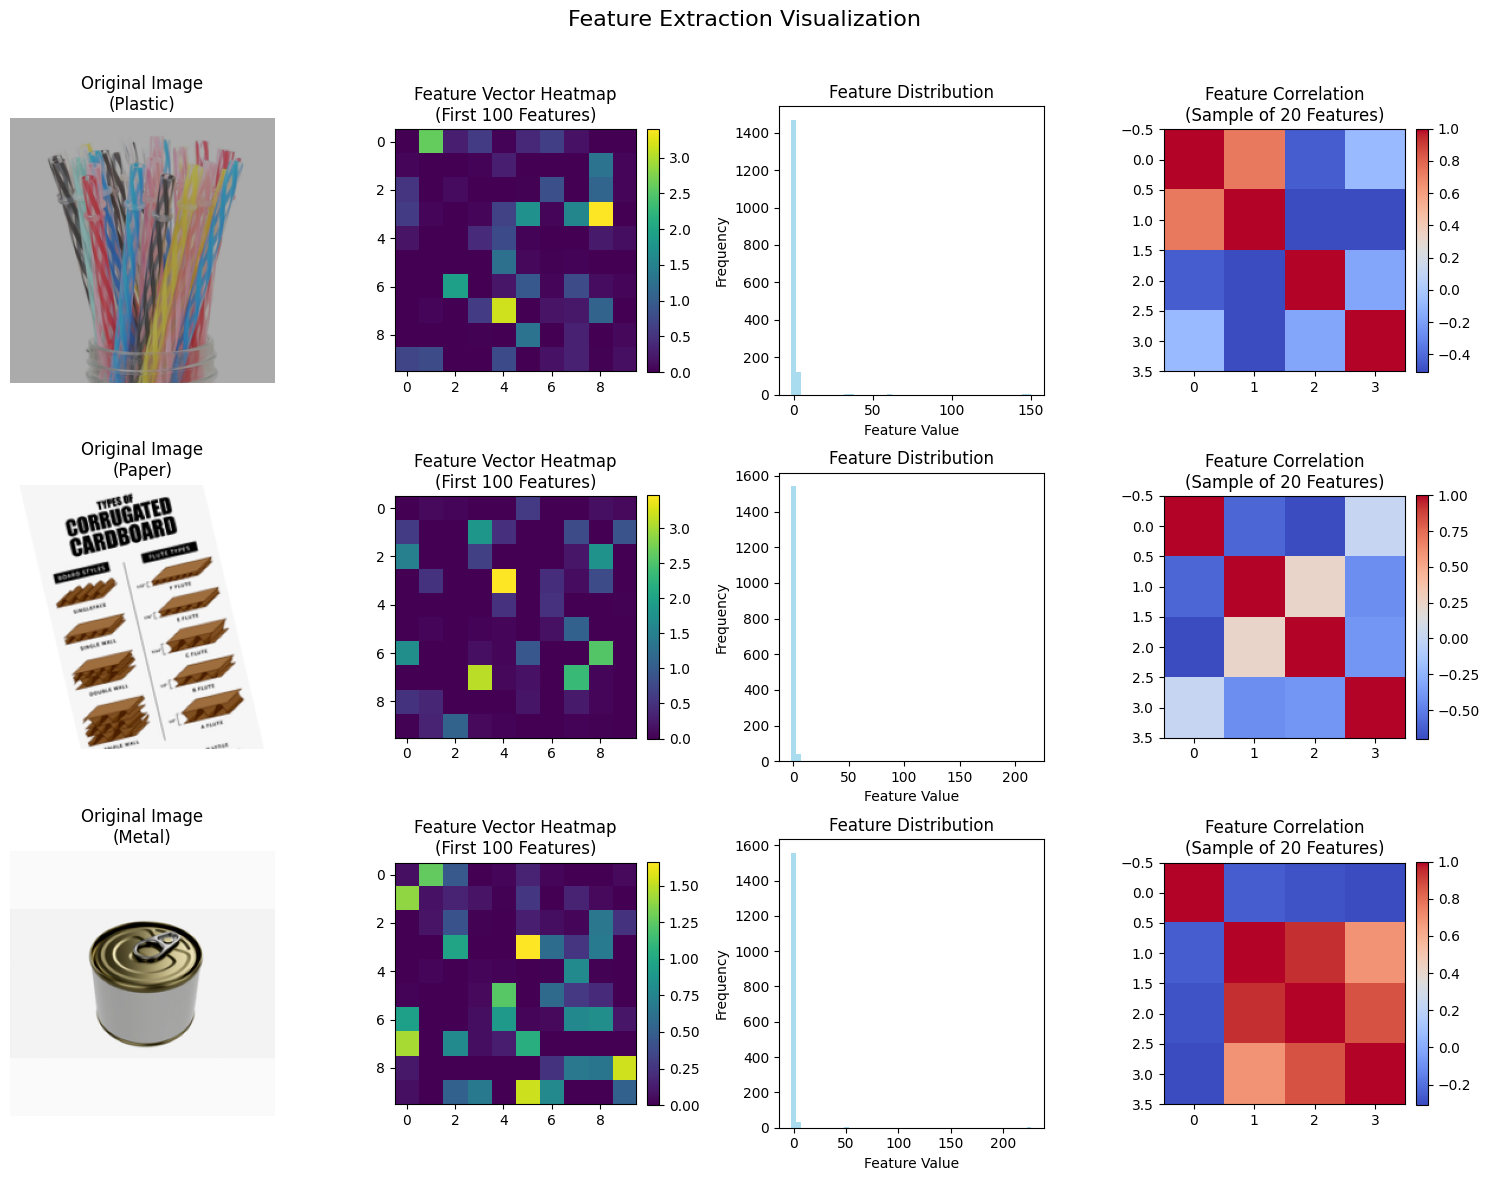

In [15]:
X_train_features = extract_features_in_batches(X_train_preprocessed, batch_size=4)

plt.figure(figsize=(15, 12))
plt.suptitle("Feature Extraction Visualization", fontsize=16)

num_examples = min(3, len(X_train_preprocessed))
example_indices = np.random.choice(len(X_train_preprocessed), num_examples, replace=False)

for i, idx in enumerate(example_indices):
    img = X_train_preprocessed[idx]
    features = X_train_features[idx]
    
    plt.subplot(num_examples, 4, i*4+1)
    plt.imshow(img)
    plt.title(f"Original Image\n({categories[train_labels[idx]]})")
    plt.axis('off')
    
    plt.subplot(num_examples, 4, i*4+2)
    features_display = features[:100].reshape(10, 10)
    plt.imshow(features_display, cmap='viridis')
    plt.title("Feature Vector Heatmap\n(First 100 Features)")
    plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(num_examples, 4, i*4+3)
    plt.hist(features, bins=50, color='skyblue', alpha=0.7)
    plt.title("Feature Distribution")
    plt.xlabel("Feature Value")
    plt.ylabel("Frequency")
    
    plt.subplot(num_examples, 4, i*4+4)
    sample_features = features[:20].reshape(4, 5)
    plt.imshow(np.corrcoef(sample_features), cmap='coolwarm')
    plt.title("Feature Correlation\n(Sample of 20 Features)")
    plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [16]:
X_val_features = extract_features_in_batches(X_val_preprocessed, batch_size=4)
X_test_features = extract_features_in_batches(X_test_preprocessed, batch_size=4)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

print(f"Training features shape: {X_train_features.shape}")
print(f"Validation features shape: {X_val_features.shape}")
print(f"Test features shape: {X_test_features.shape}")

Extracting features batch 1/507 (0:4)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 2/507 (4:8)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 3/507 (8:12)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 4/507 (12:16)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  5.56it/s]


Extracting features batch 5/507 (16:20)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.06it/s]


Extracting features batch 6/507 (20:24)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 7/507 (24:28)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


Extracting features batch 8/507 (28:32)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


Extracting features batch 9/507 (32:36)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.90it/s]


Extracting features batch 10/507 (36:40)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


Extracting features batch 11/507 (40:44)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 12/507 (44:48)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.01it/s]


Extracting features batch 13/507 (48:52)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Extracting features batch 14/507 (52:56)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 15/507 (56:60)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 16/507 (60:64)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 17/507 (64:68)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 18/507 (68:72)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


Extracting features batch 19/507 (72:76)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 20/507 (76:80)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


Extracting features batch 21/507 (80:84)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


Extracting features batch 22/507 (84:88)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 23/507 (88:92)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 24/507 (92:96)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 25/507 (96:100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 26/507 (100:104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 27/507 (104:108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 28/507 (108:112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 29/507 (112:116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 30/507 (116:120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 31/507 (120:124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 32/507 (124:128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 33/507 (128:132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 34/507 (132:136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 35/507 (136:140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 36/507 (140:144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 37/507 (144:148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 38/507 (148:152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 39/507 (152:156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 40/507 (156:160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 41/507 (160:164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 42/507 (164:168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 43/507 (168:172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 44/507 (172:176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 45/507 (176:180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 46/507 (180:184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 47/507 (184:188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 48/507 (188:192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 49/507 (192:196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 50/507 (196:200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 51/507 (200:204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 52/507 (204:208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 53/507 (208:212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 54/507 (212:216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 55/507 (216:220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 56/507 (220:224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 57/507 (224:228)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 58/507 (228:232)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 59/507 (232:236)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 60/507 (236:240)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 61/507 (240:244)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 62/507 (244:248)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 63/507 (248:252)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 64/507 (252:256)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 65/507 (256:260)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 66/507 (260:264)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 67/507 (264:268)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 68/507 (268:272)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 69/507 (272:276)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 70/507 (276:280)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 71/507 (280:284)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 72/507 (284:288)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 73/507 (288:292)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 74/507 (292:296)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 75/507 (296:300)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 76/507 (300:304)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 77/507 (304:308)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 78/507 (308:312)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 79/507 (312:316)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 80/507 (316:320)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 81/507 (320:324)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 82/507 (324:328)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 83/507 (328:332)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 84/507 (332:336)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 85/507 (336:340)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 86/507 (340:344)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 87/507 (344:348)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 88/507 (348:352)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 89/507 (352:356)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 90/507 (356:360)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 91/507 (360:364)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 92/507 (364:368)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 93/507 (368:372)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 94/507 (372:376)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 95/507 (376:380)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 96/507 (380:384)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 97/507 (384:388)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 98/507 (388:392)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.28it/s]


Extracting features batch 99/507 (392:396)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 100/507 (396:400)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 101/507 (400:404)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 102/507 (404:408)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 103/507 (408:412)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 104/507 (412:416)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 105/507 (416:420)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 106/507 (420:424)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 107/507 (424:428)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 108/507 (428:432)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 109/507 (432:436)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 110/507 (436:440)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 111/507 (440:444)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 112/507 (444:448)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 113/507 (448:452)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 114/507 (452:456)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 115/507 (456:460)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 116/507 (460:464)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 117/507 (464:468)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 118/507 (468:472)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 119/507 (472:476)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 120/507 (476:480)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 121/507 (480:484)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 122/507 (484:488)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 123/507 (488:492)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 124/507 (492:496)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 125/507 (496:500)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 126/507 (500:504)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 127/507 (504:508)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 128/507 (508:512)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 129/507 (512:516)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 130/507 (516:520)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 131/507 (520:524)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 132/507 (524:528)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 133/507 (528:532)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 134/507 (532:536)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 135/507 (536:540)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 136/507 (540:544)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 137/507 (544:548)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 138/507 (548:552)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 139/507 (552:556)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 140/507 (556:560)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 141/507 (560:564)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 142/507 (564:568)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 143/507 (568:572)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 144/507 (572:576)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 145/507 (576:580)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 146/507 (580:584)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 147/507 (584:588)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 148/507 (588:592)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 149/507 (592:596)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 150/507 (596:600)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 151/507 (600:604)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 152/507 (604:608)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 153/507 (608:612)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 154/507 (612:616)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 155/507 (616:620)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 156/507 (620:624)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 157/507 (624:628)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Extracting features batch 158/507 (628:632)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 159/507 (632:636)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 160/507 (636:640)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 161/507 (640:644)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 162/507 (644:648)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 163/507 (648:652)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 164/507 (652:656)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 165/507 (656:660)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 166/507 (660:664)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 167/507 (664:668)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Extracting features batch 168/507 (668:672)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Extracting features batch 169/507 (672:676)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 170/507 (676:680)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 171/507 (680:684)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 172/507 (684:688)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 173/507 (688:692)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 174/507 (692:696)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 175/507 (696:700)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 176/507 (700:704)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 177/507 (704:708)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 178/507 (708:712)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 179/507 (712:716)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 180/507 (716:720)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 181/507 (720:724)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 182/507 (724:728)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 183/507 (728:732)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 184/507 (732:736)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 185/507 (736:740)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 186/507 (740:744)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 187/507 (744:748)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 188/507 (748:752)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 189/507 (752:756)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 190/507 (756:760)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Extracting features batch 191/507 (760:764)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Extracting features batch 192/507 (764:768)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 193/507 (768:772)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Extracting features batch 194/507 (772:776)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 195/507 (776:780)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 196/507 (780:784)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 197/507 (784:788)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 198/507 (788:792)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 199/507 (792:796)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 200/507 (796:800)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 201/507 (800:804)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 202/507 (804:808)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 203/507 (808:812)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 204/507 (812:816)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Extracting features batch 205/507 (816:820)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 206/507 (820:824)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 207/507 (824:828)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


Extracting features batch 208/507 (828:832)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 209/507 (832:836)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 210/507 (836:840)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 211/507 (840:844)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 212/507 (844:848)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 213/507 (848:852)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 214/507 (852:856)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 215/507 (856:860)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Extracting features batch 216/507 (860:864)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 217/507 (864:868)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 218/507 (868:872)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Extracting features batch 219/507 (872:876)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 220/507 (876:880)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Extracting features batch 221/507 (880:884)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 222/507 (884:888)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Extracting features batch 223/507 (888:892)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 224/507 (892:896)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Extracting features batch 225/507 (896:900)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 226/507 (900:904)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Extracting features batch 227/507 (904:908)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 228/507 (908:912)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Extracting features batch 229/507 (912:916)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Extracting features batch 230/507 (916:920)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Extracting features batch 231/507 (920:924)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 232/507 (924:928)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 233/507 (928:932)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 234/507 (932:936)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 235/507 (936:940)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 236/507 (940:944)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 237/507 (944:948)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Extracting features batch 238/507 (948:952)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 239/507 (952:956)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 240/507 (956:960)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Extracting features batch 241/507 (960:964)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 242/507 (964:968)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 243/507 (968:972)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 244/507 (972:976)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 245/507 (976:980)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 246/507 (980:984)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


Extracting features batch 247/507 (984:988)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 248/507 (988:992)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 249/507 (992:996)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 250/507 (996:1000)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Extracting features batch 251/507 (1000:1004)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Extracting features batch 252/507 (1004:1008)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 253/507 (1008:1012)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Extracting features batch 254/507 (1012:1016)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 255/507 (1016:1020)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 256/507 (1020:1024)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 257/507 (1024:1028)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 258/507 (1028:1032)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 259/507 (1032:1036)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 260/507 (1036:1040)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 261/507 (1040:1044)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 262/507 (1044:1048)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 263/507 (1048:1052)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 264/507 (1052:1056)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 265/507 (1056:1060)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 266/507 (1060:1064)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 267/507 (1064:1068)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 268/507 (1068:1072)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 269/507 (1072:1076)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 270/507 (1076:1080)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


Extracting features batch 271/507 (1080:1084)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 272/507 (1084:1088)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 273/507 (1088:1092)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 274/507 (1092:1096)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 275/507 (1096:1100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 276/507 (1100:1104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 277/507 (1104:1108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 278/507 (1108:1112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 279/507 (1112:1116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 280/507 (1116:1120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 281/507 (1120:1124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 282/507 (1124:1128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 283/507 (1128:1132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Extracting features batch 284/507 (1132:1136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 285/507 (1136:1140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 286/507 (1140:1144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 287/507 (1144:1148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 288/507 (1148:1152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 289/507 (1152:1156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 290/507 (1156:1160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Extracting features batch 291/507 (1160:1164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 292/507 (1164:1168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 293/507 (1168:1172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 294/507 (1172:1176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Extracting features batch 295/507 (1176:1180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 296/507 (1180:1184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 297/507 (1184:1188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Extracting features batch 298/507 (1188:1192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 299/507 (1192:1196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 300/507 (1196:1200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Extracting features batch 301/507 (1200:1204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 302/507 (1204:1208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 303/507 (1208:1212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Extracting features batch 304/507 (1212:1216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 305/507 (1216:1220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


Extracting features batch 306/507 (1220:1224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Extracting features batch 307/507 (1224:1228)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Extracting features batch 308/507 (1228:1232)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Extracting features batch 309/507 (1232:1236)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 310/507 (1236:1240)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 311/507 (1240:1244)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Extracting features batch 312/507 (1244:1248)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


Extracting features batch 313/507 (1248:1252)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Extracting features batch 314/507 (1252:1256)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 315/507 (1256:1260)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


Extracting features batch 316/507 (1260:1264)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 317/507 (1264:1268)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 318/507 (1268:1272)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 319/507 (1272:1276)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Extracting features batch 320/507 (1276:1280)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Extracting features batch 321/507 (1280:1284)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


Extracting features batch 322/507 (1284:1288)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 323/507 (1288:1292)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 324/507 (1292:1296)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 325/507 (1296:1300)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


Extracting features batch 326/507 (1300:1304)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 327/507 (1304:1308)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 328/507 (1308:1312)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Extracting features batch 329/507 (1312:1316)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Extracting features batch 330/507 (1316:1320)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 331/507 (1320:1324)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 332/507 (1324:1328)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 333/507 (1328:1332)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 334/507 (1332:1336)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 335/507 (1336:1340)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 336/507 (1340:1344)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 337/507 (1344:1348)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 338/507 (1348:1352)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 339/507 (1352:1356)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Extracting features batch 340/507 (1356:1360)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Extracting features batch 341/507 (1360:1364)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


Extracting features batch 342/507 (1364:1368)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


Extracting features batch 343/507 (1368:1372)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Extracting features batch 344/507 (1372:1376)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Extracting features batch 345/507 (1376:1380)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 346/507 (1380:1384)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Extracting features batch 347/507 (1384:1388)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 348/507 (1388:1392)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


Extracting features batch 349/507 (1392:1396)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


Extracting features batch 350/507 (1396:1400)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Extracting features batch 351/507 (1400:1404)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Extracting features batch 352/507 (1404:1408)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 353/507 (1408:1412)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 354/507 (1412:1416)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Extracting features batch 355/507 (1416:1420)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Extracting features batch 356/507 (1420:1424)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Extracting features batch 357/507 (1424:1428)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Extracting features batch 358/507 (1428:1432)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


Extracting features batch 359/507 (1432:1436)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Extracting features batch 360/507 (1436:1440)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


Extracting features batch 361/507 (1440:1444)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Extracting features batch 362/507 (1444:1448)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


Extracting features batch 363/507 (1448:1452)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Extracting features batch 364/507 (1452:1456)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Extracting features batch 365/507 (1456:1460)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


Extracting features batch 366/507 (1460:1464)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Extracting features batch 367/507 (1464:1468)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


Extracting features batch 368/507 (1468:1472)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 369/507 (1472:1476)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


Extracting features batch 370/507 (1476:1480)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Extracting features batch 371/507 (1480:1484)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 372/507 (1484:1488)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Extracting features batch 373/507 (1488:1492)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


Extracting features batch 374/507 (1492:1496)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 375/507 (1496:1500)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.24it/s]


Extracting features batch 376/507 (1500:1504)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Extracting features batch 377/507 (1504:1508)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 378/507 (1508:1512)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


Extracting features batch 379/507 (1512:1516)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Extracting features batch 380/507 (1516:1520)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


Extracting features batch 381/507 (1520:1524)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Extracting features batch 382/507 (1524:1528)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 383/507 (1528:1532)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


Extracting features batch 384/507 (1532:1536)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


Extracting features batch 385/507 (1536:1540)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.88it/s]


Extracting features batch 386/507 (1540:1544)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.90it/s]


Extracting features batch 387/507 (1544:1548)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 388/507 (1548:1552)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 389/507 (1552:1556)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.76it/s]


Extracting features batch 390/507 (1556:1560)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 391/507 (1560:1564)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 392/507 (1564:1568)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


Extracting features batch 393/507 (1568:1572)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 394/507 (1572:1576)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 395/507 (1576:1580)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  5.75it/s]


Extracting features batch 396/507 (1580:1584)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


Extracting features batch 397/507 (1584:1588)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 398/507 (1588:1592)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 399/507 (1592:1596)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 400/507 (1596:1600)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 401/507 (1600:1604)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 402/507 (1604:1608)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


Extracting features batch 403/507 (1608:1612)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 404/507 (1612:1616)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 405/507 (1616:1620)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 406/507 (1620:1624)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 407/507 (1624:1628)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 408/507 (1628:1632)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


Extracting features batch 409/507 (1632:1636)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 410/507 (1636:1640)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 411/507 (1640:1644)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 412/507 (1644:1648)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 413/507 (1648:1652)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 414/507 (1652:1656)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 415/507 (1656:1660)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 416/507 (1660:1664)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 417/507 (1664:1668)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 418/507 (1668:1672)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 419/507 (1672:1676)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 420/507 (1676:1680)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 421/507 (1680:1684)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 422/507 (1684:1688)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 423/507 (1688:1692)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 424/507 (1692:1696)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 425/507 (1696:1700)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 426/507 (1700:1704)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 427/507 (1704:1708)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 428/507 (1708:1712)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 429/507 (1712:1716)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 430/507 (1716:1720)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 431/507 (1720:1724)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 432/507 (1724:1728)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 433/507 (1728:1732)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 434/507 (1732:1736)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 435/507 (1736:1740)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 436/507 (1740:1744)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


Extracting features batch 437/507 (1744:1748)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 438/507 (1748:1752)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 439/507 (1752:1756)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 440/507 (1756:1760)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 441/507 (1760:1764)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 442/507 (1764:1768)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 443/507 (1768:1772)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 444/507 (1772:1776)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 445/507 (1776:1780)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 446/507 (1780:1784)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 447/507 (1784:1788)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 448/507 (1788:1792)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 449/507 (1792:1796)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 450/507 (1796:1800)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 451/507 (1800:1804)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 452/507 (1804:1808)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 453/507 (1808:1812)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 454/507 (1812:1816)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 455/507 (1816:1820)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


Extracting features batch 456/507 (1820:1824)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


Extracting features batch 457/507 (1824:1828)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


Extracting features batch 458/507 (1828:1832)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 459/507 (1832:1836)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 460/507 (1836:1840)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 461/507 (1840:1844)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 462/507 (1844:1848)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 463/507 (1848:1852)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 464/507 (1852:1856)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 465/507 (1856:1860)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


Extracting features batch 466/507 (1860:1864)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 467/507 (1864:1868)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


Extracting features batch 468/507 (1868:1872)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


Extracting features batch 469/507 (1872:1876)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 470/507 (1876:1880)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 471/507 (1880:1884)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 472/507 (1884:1888)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 473/507 (1888:1892)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 474/507 (1892:1896)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 475/507 (1896:1900)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 476/507 (1900:1904)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


Extracting features batch 477/507 (1904:1908)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


Extracting features batch 478/507 (1908:1912)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.76it/s]


Extracting features batch 479/507 (1912:1916)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  5.47it/s]


Extracting features batch 480/507 (1916:1920)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 481/507 (1920:1924)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 482/507 (1924:1928)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 483/507 (1928:1932)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


Extracting features batch 484/507 (1932:1936)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


Extracting features batch 485/507 (1936:1940)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.06it/s]


Extracting features batch 486/507 (1940:1944)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.74it/s]


Extracting features batch 487/507 (1944:1948)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


Extracting features batch 488/507 (1948:1952)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.90it/s]


Extracting features batch 489/507 (1952:1956)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 490/507 (1956:1960)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


Extracting features batch 491/507 (1960:1964)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 492/507 (1964:1968)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


Extracting features batch 493/507 (1968:1972)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


Extracting features batch 494/507 (1972:1976)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 495/507 (1976:1980)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 496/507 (1980:1984)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 497/507 (1984:1988)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.45it/s]


Extracting features batch 498/507 (1988:1992)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 499/507 (1992:1996)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


Extracting features batch 500/507 (1996:2000)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


Extracting features batch 501/507 (2000:2004)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.67it/s]


Extracting features batch 502/507 (2004:2008)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.62it/s]


Extracting features batch 503/507 (2008:2012)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


Extracting features batch 504/507 (2012:2016)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


Extracting features batch 505/507 (2016:2020)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 506/507 (2020:2024)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 507/507 (2024:2025)


Extracting features: 100%|████████████████████████| 1/1 [00:00<00:00,  7.02it/s]


Extracting features batch 1/507 (0:4)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


Extracting features batch 2/507 (4:8)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.82it/s]


Extracting features batch 3/507 (8:12)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


Extracting features batch 4/507 (12:16)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.90it/s]


Extracting features batch 5/507 (16:20)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


Extracting features batch 6/507 (20:24)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 7/507 (24:28)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.90it/s]


Extracting features batch 8/507 (28:32)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


Extracting features batch 9/507 (32:36)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 10/507 (36:40)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


Extracting features batch 11/507 (40:44)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


Extracting features batch 12/507 (44:48)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 13/507 (48:52)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 14/507 (52:56)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.83it/s]


Extracting features batch 15/507 (56:60)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.59it/s]


Extracting features batch 16/507 (60:64)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


Extracting features batch 17/507 (64:68)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 18/507 (68:72)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 19/507 (72:76)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 20/507 (76:80)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 21/507 (80:84)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 22/507 (84:88)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 23/507 (88:92)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 24/507 (92:96)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 25/507 (96:100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 26/507 (100:104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 27/507 (104:108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 28/507 (108:112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 29/507 (112:116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 30/507 (116:120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 31/507 (120:124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 32/507 (124:128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 33/507 (128:132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 34/507 (132:136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 35/507 (136:140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 36/507 (140:144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 37/507 (144:148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 38/507 (148:152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 39/507 (152:156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 40/507 (156:160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 41/507 (160:164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 42/507 (164:168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 43/507 (168:172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 44/507 (172:176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 45/507 (176:180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 46/507 (180:184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 47/507 (184:188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 48/507 (188:192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 49/507 (192:196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 50/507 (196:200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 51/507 (200:204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 52/507 (204:208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 53/507 (208:212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


Extracting features batch 54/507 (212:216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 55/507 (216:220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 56/507 (220:224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 57/507 (224:228)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 58/507 (228:232)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 59/507 (232:236)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 60/507 (236:240)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 61/507 (240:244)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 62/507 (244:248)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 63/507 (248:252)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 64/507 (252:256)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 65/507 (256:260)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 66/507 (260:264)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 67/507 (264:268)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 68/507 (268:272)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 69/507 (272:276)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 70/507 (276:280)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 71/507 (280:284)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 72/507 (284:288)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.06it/s]


Extracting features batch 73/507 (288:292)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 74/507 (292:296)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 75/507 (296:300)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 76/507 (300:304)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 77/507 (304:308)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 78/507 (308:312)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 79/507 (312:316)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 80/507 (316:320)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 81/507 (320:324)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 82/507 (324:328)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 83/507 (328:332)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Extracting features batch 84/507 (332:336)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 85/507 (336:340)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


Extracting features batch 86/507 (340:344)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 87/507 (344:348)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 88/507 (348:352)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 89/507 (352:356)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 90/507 (356:360)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


Extracting features batch 91/507 (360:364)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 92/507 (364:368)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 93/507 (368:372)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 94/507 (372:376)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 95/507 (376:380)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 96/507 (380:384)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 97/507 (384:388)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 98/507 (388:392)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 99/507 (392:396)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 100/507 (396:400)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 101/507 (400:404)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 102/507 (404:408)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 103/507 (408:412)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 104/507 (412:416)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 105/507 (416:420)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 106/507 (420:424)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 107/507 (424:428)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 108/507 (428:432)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 109/507 (432:436)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 110/507 (436:440)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 111/507 (440:444)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 112/507 (444:448)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 113/507 (448:452)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 114/507 (452:456)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 115/507 (456:460)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 116/507 (460:464)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 117/507 (464:468)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 118/507 (468:472)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 119/507 (472:476)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


Extracting features batch 120/507 (476:480)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 121/507 (480:484)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 122/507 (484:488)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 123/507 (488:492)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


Extracting features batch 124/507 (492:496)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.17it/s]


Extracting features batch 125/507 (496:500)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 126/507 (500:504)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 127/507 (504:508)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 128/507 (508:512)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 129/507 (512:516)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 130/507 (516:520)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 131/507 (520:524)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 132/507 (524:528)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 133/507 (528:532)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 134/507 (532:536)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 135/507 (536:540)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 136/507 (540:544)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


Extracting features batch 137/507 (544:548)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 138/507 (548:552)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 139/507 (552:556)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 140/507 (556:560)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 141/507 (560:564)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 142/507 (564:568)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 143/507 (568:572)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 144/507 (572:576)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 145/507 (576:580)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 146/507 (580:584)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 147/507 (584:588)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 148/507 (588:592)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 149/507 (592:596)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 150/507 (596:600)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 151/507 (600:604)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 152/507 (604:608)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 153/507 (608:612)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 154/507 (612:616)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 155/507 (616:620)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 156/507 (620:624)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 157/507 (624:628)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 158/507 (628:632)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 159/507 (632:636)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 160/507 (636:640)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 161/507 (640:644)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 162/507 (644:648)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 163/507 (648:652)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 164/507 (652:656)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 165/507 (656:660)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 166/507 (660:664)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 167/507 (664:668)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 168/507 (668:672)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


Extracting features batch 169/507 (672:676)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 170/507 (676:680)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 171/507 (680:684)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 172/507 (684:688)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 173/507 (688:692)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 174/507 (692:696)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 175/507 (696:700)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 176/507 (700:704)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 177/507 (704:708)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 178/507 (708:712)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 179/507 (712:716)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 180/507 (716:720)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 181/507 (720:724)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 182/507 (724:728)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 183/507 (728:732)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Extracting features batch 184/507 (732:736)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 185/507 (736:740)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 186/507 (740:744)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


Extracting features batch 187/507 (744:748)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 188/507 (748:752)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.89it/s]


Extracting features batch 189/507 (752:756)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


Extracting features batch 190/507 (756:760)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 191/507 (760:764)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 192/507 (764:768)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 193/507 (768:772)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 194/507 (772:776)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 195/507 (776:780)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 196/507 (780:784)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 197/507 (784:788)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 198/507 (788:792)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 199/507 (792:796)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 200/507 (796:800)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 201/507 (800:804)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 202/507 (804:808)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 203/507 (808:812)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 204/507 (812:816)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 205/507 (816:820)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 206/507 (820:824)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 207/507 (824:828)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 208/507 (828:832)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 209/507 (832:836)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 210/507 (836:840)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 211/507 (840:844)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 212/507 (844:848)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 213/507 (848:852)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 214/507 (852:856)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 215/507 (856:860)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 216/507 (860:864)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


Extracting features batch 217/507 (864:868)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


Extracting features batch 218/507 (868:872)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 219/507 (872:876)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 220/507 (876:880)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 221/507 (880:884)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 222/507 (884:888)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 223/507 (888:892)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 224/507 (892:896)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 225/507 (896:900)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 226/507 (900:904)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 227/507 (904:908)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 228/507 (908:912)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 229/507 (912:916)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 230/507 (916:920)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 231/507 (920:924)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 232/507 (924:928)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 233/507 (928:932)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 234/507 (932:936)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 235/507 (936:940)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 236/507 (940:944)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 237/507 (944:948)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 238/507 (948:952)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 239/507 (952:956)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 240/507 (956:960)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 241/507 (960:964)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 242/507 (964:968)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 243/507 (968:972)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 244/507 (972:976)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 245/507 (976:980)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 246/507 (980:984)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


Extracting features batch 247/507 (984:988)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


Extracting features batch 248/507 (988:992)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 249/507 (992:996)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.03it/s]


Extracting features batch 250/507 (996:1000)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


Extracting features batch 251/507 (1000:1004)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 252/507 (1004:1008)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 253/507 (1008:1012)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


Extracting features batch 254/507 (1012:1016)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 255/507 (1016:1020)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 256/507 (1020:1024)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 257/507 (1024:1028)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 258/507 (1028:1032)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 259/507 (1032:1036)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 260/507 (1036:1040)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 261/507 (1040:1044)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 262/507 (1044:1048)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 263/507 (1048:1052)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 264/507 (1052:1056)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 265/507 (1056:1060)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 266/507 (1060:1064)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 267/507 (1064:1068)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 268/507 (1068:1072)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 269/507 (1072:1076)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 270/507 (1076:1080)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 271/507 (1080:1084)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 272/507 (1084:1088)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 273/507 (1088:1092)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 274/507 (1092:1096)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


Extracting features batch 275/507 (1096:1100)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 276/507 (1100:1104)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


Extracting features batch 277/507 (1104:1108)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 278/507 (1108:1112)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 279/507 (1112:1116)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 280/507 (1116:1120)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 281/507 (1120:1124)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 282/507 (1124:1128)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 283/507 (1128:1132)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 284/507 (1132:1136)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 285/507 (1136:1140)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 286/507 (1140:1144)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 287/507 (1144:1148)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 288/507 (1148:1152)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 289/507 (1152:1156)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 290/507 (1156:1160)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


Extracting features batch 291/507 (1160:1164)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 292/507 (1164:1168)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 293/507 (1168:1172)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 294/507 (1172:1176)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 295/507 (1176:1180)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 296/507 (1180:1184)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 297/507 (1184:1188)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 298/507 (1188:1192)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 299/507 (1192:1196)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 300/507 (1196:1200)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 301/507 (1200:1204)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 302/507 (1204:1208)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 303/507 (1208:1212)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 304/507 (1212:1216)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 305/507 (1216:1220)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 306/507 (1220:1224)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 307/507 (1224:1228)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


Extracting features batch 308/507 (1228:1232)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


Extracting features batch 309/507 (1232:1236)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 310/507 (1236:1240)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 311/507 (1240:1244)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 312/507 (1244:1248)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 313/507 (1248:1252)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 314/507 (1252:1256)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 315/507 (1256:1260)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 316/507 (1260:1264)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


Extracting features batch 317/507 (1264:1268)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 318/507 (1268:1272)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 319/507 (1272:1276)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 320/507 (1276:1280)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 321/507 (1280:1284)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 322/507 (1284:1288)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 323/507 (1288:1292)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 324/507 (1292:1296)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 325/507 (1296:1300)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 326/507 (1300:1304)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 327/507 (1304:1308)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 328/507 (1308:1312)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 329/507 (1312:1316)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 330/507 (1316:1320)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 331/507 (1320:1324)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


Extracting features batch 332/507 (1324:1328)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


Extracting features batch 333/507 (1328:1332)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 334/507 (1332:1336)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 335/507 (1336:1340)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 336/507 (1340:1344)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 337/507 (1344:1348)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 338/507 (1348:1352)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 339/507 (1352:1356)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 340/507 (1356:1360)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 341/507 (1360:1364)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 342/507 (1364:1368)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 343/507 (1368:1372)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 344/507 (1372:1376)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 345/507 (1376:1380)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 346/507 (1380:1384)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 347/507 (1384:1388)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 348/507 (1388:1392)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 349/507 (1392:1396)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 350/507 (1396:1400)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 351/507 (1400:1404)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 352/507 (1404:1408)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 353/507 (1408:1412)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 354/507 (1412:1416)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 355/507 (1416:1420)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 356/507 (1420:1424)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


Extracting features batch 357/507 (1424:1428)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 358/507 (1428:1432)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


Extracting features batch 359/507 (1432:1436)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 360/507 (1436:1440)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 361/507 (1440:1444)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 362/507 (1444:1448)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 363/507 (1448:1452)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 364/507 (1452:1456)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 365/507 (1456:1460)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 366/507 (1460:1464)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 367/507 (1464:1468)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 368/507 (1468:1472)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 369/507 (1472:1476)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 370/507 (1476:1480)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 371/507 (1480:1484)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.06it/s]


Extracting features batch 372/507 (1484:1488)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 373/507 (1488:1492)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 374/507 (1492:1496)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


Extracting features batch 375/507 (1496:1500)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


Extracting features batch 376/507 (1500:1504)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 377/507 (1504:1508)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 378/507 (1508:1512)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


Extracting features batch 379/507 (1512:1516)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 380/507 (1516:1520)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 381/507 (1520:1524)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 382/507 (1524:1528)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 383/507 (1528:1532)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


Extracting features batch 384/507 (1532:1536)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 385/507 (1536:1540)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 386/507 (1540:1544)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 387/507 (1544:1548)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 388/507 (1548:1552)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 389/507 (1552:1556)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 390/507 (1556:1560)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 391/507 (1560:1564)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 392/507 (1564:1568)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Extracting features batch 393/507 (1568:1572)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


Extracting features batch 394/507 (1572:1576)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 395/507 (1576:1580)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


Extracting features batch 396/507 (1580:1584)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Extracting features batch 397/507 (1584:1588)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


Extracting features batch 398/507 (1588:1592)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 399/507 (1592:1596)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 400/507 (1596:1600)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 401/507 (1600:1604)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 402/507 (1604:1608)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 403/507 (1608:1612)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 404/507 (1612:1616)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 405/507 (1616:1620)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 406/507 (1620:1624)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 407/507 (1624:1628)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


Extracting features batch 408/507 (1628:1632)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Extracting features batch 409/507 (1632:1636)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 410/507 (1636:1640)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 411/507 (1640:1644)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 412/507 (1644:1648)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


Extracting features batch 413/507 (1648:1652)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 414/507 (1652:1656)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


Extracting features batch 415/507 (1656:1660)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.33it/s]


Extracting features batch 416/507 (1660:1664)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


Extracting features batch 417/507 (1664:1668)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 418/507 (1668:1672)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 419/507 (1672:1676)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 420/507 (1676:1680)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 421/507 (1680:1684)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 422/507 (1684:1688)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 423/507 (1688:1692)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 424/507 (1692:1696)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


Extracting features batch 425/507 (1696:1700)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


Extracting features batch 426/507 (1700:1704)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 427/507 (1704:1708)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 428/507 (1708:1712)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


Extracting features batch 429/507 (1712:1716)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


Extracting features batch 430/507 (1716:1720)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.73it/s]


Extracting features batch 431/507 (1720:1724)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 432/507 (1724:1728)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 433/507 (1728:1732)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


Extracting features batch 434/507 (1732:1736)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


Extracting features batch 435/507 (1736:1740)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 436/507 (1740:1744)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 437/507 (1744:1748)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 438/507 (1748:1752)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 439/507 (1752:1756)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


Extracting features batch 440/507 (1756:1760)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 441/507 (1760:1764)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 442/507 (1764:1768)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 443/507 (1768:1772)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


Extracting features batch 444/507 (1772:1776)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


Extracting features batch 445/507 (1776:1780)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 446/507 (1780:1784)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


Extracting features batch 447/507 (1784:1788)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 448/507 (1788:1792)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 449/507 (1792:1796)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


Extracting features batch 450/507 (1796:1800)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 451/507 (1800:1804)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 452/507 (1804:1808)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


Extracting features batch 453/507 (1808:1812)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 454/507 (1812:1816)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 455/507 (1816:1820)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 456/507 (1820:1824)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 457/507 (1824:1828)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


Extracting features batch 458/507 (1828:1832)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


Extracting features batch 459/507 (1832:1836)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 460/507 (1836:1840)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 461/507 (1840:1844)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 462/507 (1844:1848)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


Extracting features batch 463/507 (1848:1852)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 464/507 (1852:1856)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


Extracting features batch 465/507 (1856:1860)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


Extracting features batch 466/507 (1860:1864)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


Extracting features batch 467/507 (1864:1868)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 468/507 (1868:1872)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 469/507 (1872:1876)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.82it/s]


Extracting features batch 470/507 (1876:1880)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 471/507 (1880:1884)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Extracting features batch 472/507 (1884:1888)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 473/507 (1888:1892)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


Extracting features batch 474/507 (1892:1896)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


Extracting features batch 475/507 (1896:1900)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 476/507 (1900:1904)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 477/507 (1904:1908)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


Extracting features batch 478/507 (1908:1912)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 479/507 (1912:1916)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


Extracting features batch 480/507 (1916:1920)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 481/507 (1920:1924)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


Extracting features batch 482/507 (1924:1928)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 483/507 (1928:1932)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 484/507 (1932:1936)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


Extracting features batch 485/507 (1936:1940)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 486/507 (1940:1944)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


Extracting features batch 487/507 (1944:1948)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 488/507 (1948:1952)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


Extracting features batch 489/507 (1952:1956)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


Extracting features batch 490/507 (1956:1960)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


Extracting features batch 491/507 (1960:1964)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Extracting features batch 492/507 (1964:1968)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Extracting features batch 493/507 (1968:1972)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Extracting features batch 494/507 (1972:1976)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Extracting features batch 495/507 (1976:1980)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


Extracting features batch 496/507 (1980:1984)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


Extracting features batch 497/507 (1984:1988)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


Extracting features batch 498/507 (1988:1992)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


Extracting features batch 499/507 (1992:1996)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


Extracting features batch 500/507 (1996:2000)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


Extracting features batch 501/507 (2000:2004)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Extracting features batch 502/507 (2004:2008)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


Extracting features batch 503/507 (2008:2012)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


Extracting features batch 504/507 (2012:2016)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


Extracting features batch 505/507 (2016:2020)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


Extracting features batch 506/507 (2020:2024)


Extracting features: 100%|████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Extracting features batch 507/507 (2024:2025)


Extracting features: 100%|████████████████████████| 1/1 [00:00<00:00,  7.47it/s]


Training features shape: (9450, 1598)
Validation features shape: (2025, 1598)
Test features shape: (2025, 1598)



[4] Applying feature preprocessing...
Processed feature shapes:
  Training: (9450, 1598)
  Validation: (2025, 1598)
  Test: (2025, 1598)


/home/x/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


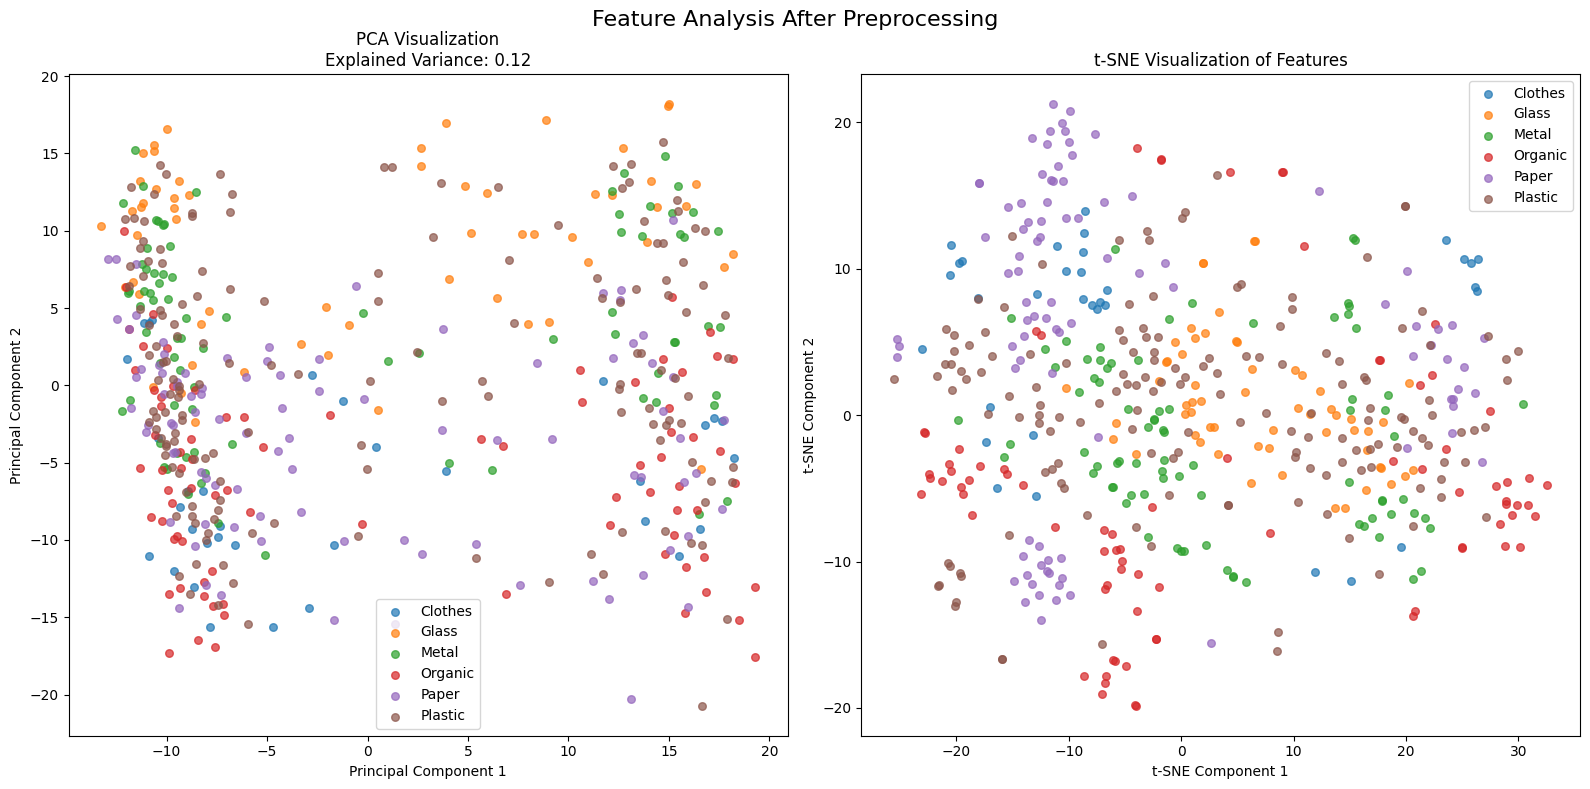

In [17]:
print("\n[4] Applying feature preprocessing...")

X_train_features = np.nan_to_num(X_train_features)
X_val_features = np.nan_to_num(X_val_features)
X_test_features = np.nan_to_num(X_test_features)

scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train_features)
X_val_processed = scaler.transform(X_val_features)
X_test_processed = scaler.transform(X_test_features)

print(f"Processed feature shapes:")
print(f"  Training: {X_train_processed.shape}")
print(f"  Validation: {X_val_processed.shape}")
print(f"  Test: {X_test_processed.shape}")

plt.figure(figsize=(16, 8))
plt.suptitle("Feature Analysis After Preprocessing", fontsize=16)

sample_size = min(500, len(X_train_processed))
indices = np.random.choice(len(X_train_processed), sample_size, replace=False)
X_sample = X_train_processed[indices]
y_sample = train_labels[indices]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

try:
    tsne = TSNE(n_components=2, random_state=42, n_iter=1000)
    X_tsne = tsne.fit_transform(X_sample)
    
    plt.subplot(1, 2, 1)
    for i, category in enumerate(categories):
        plt.scatter(X_pca[y_sample == i, 0], X_pca[y_sample == i, 1], 
                    label=category, alpha=0.7, s=30)
    plt.title(f"PCA Visualization\nExplained Variance: {pca.explained_variance_ratio_.sum():.2f}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for i, category in enumerate(categories):
        plt.scatter(X_tsne[y_sample == i, 0], X_tsne[y_sample == i, 1], 
                    label=category, alpha=0.7, s=30)
    plt.title("t-SNE Visualization of Features")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    
except Exception as e:
    print(f"Could not compute t-SNE: {e}")
    
    plt.subplot(1, 1, 1)
    for i, category in enumerate(categories):
        plt.scatter(X_pca[y_sample == i, 0], X_pca[y_sample == i, 1], 
                    label=category, alpha=0.7, s=30)
    plt.title(f"PCA Visualization\nExplained Variance: {pca.explained_variance_ratio_.sum():.2f}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [18]:
print("\n[5] Training model with anti-overfitting measures...")

class_counts = np.bincount(train_labels)
total_samples = len(train_labels)

class_weights = {}
for i in range(len(categories)):
    if i in class_counts and class_counts[i] > 0:
        class_weights[i] = total_samples / (len(categories) * class_counts[i])
    else:
        class_weights[i] = 1.0

print(f"Class weights: {class_weights}")

classifier = CustomClassifier(
    input_shape=X_train_processed.shape[1],
    num_classes=len(categories),
    learning_rate=0.0005,
    dropout_rate=0.6,
    l2_reg=0.02
)


max_samples = min(4000, len(X_train_processed))


[5] Training model with anti-overfitting measures...
Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0}
Building model for input shape: 1598 with 6 classes


/home/x/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       204,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,806 (878.15 KB)

 Trainable params: 224,230 (875.90 KB)

 Non-trainable params: 576 (2.25 KB)

Training shapes: (9450, 1598) (9450,)
Validation shapes: (2025, 1598) (2025,)
Class distribution in training set:
  Class 0: 700 samples
  Class 1: 1050 samples
  Class 2: 1400 samples
  Class 3: 1400 samples
  Class 4: 1750 samples
  Class 5: 3150 samples
Using 3997 samples for training to reduce overfitting
Epoch 1/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1837 - loss: 15.6927

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1846 - loss: 15.6561 - val_accuracy: 0.5877 - val_loss: 11.8439 - learning_rate: 5.0000e-04
Epoch 2/30
52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3273 - loss: 11.4896

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3315 - loss: 11.3389 - val_accuracy: 0.7467 - val_loss: 8.6559 - learning_rate: 5.0000e-04
Epoch 3/30
54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4376 - loss: 8.4733

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4421 - loss: 8.3790 - val_accuracy: 0.7649 - val_loss: 6.3950 - learning_rate: 5.0000e-04
Epoch 4/30
52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5285 - loss: 6.3390

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5324 - loss: 6.2611 - val_accuracy: 0.7872 - val_loss: 4.8243 - learning_rate: 5.0000e-04
Epoch 5/30
55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6103 - loss: 4.7883

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6134 - loss: 4.7467 - val_accuracy: 0.8247 - val_loss: 3.7390 - learning_rate: 5.0000e-04
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6660 - loss: 3.7226 - val_accuracy: 0.8242 - val_loss: 2.9858 - learning_rate: 5.0000e-04
Epoch 7/30
56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7128 - loss: 2.9841

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7133 - loss: 2.9676 - val_accuracy: 0.8331 - val_loss: 2.4471 - learning_rate: 5.0000e-04
Epoch 8/30
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7448 - loss: 2.4673

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7454 - loss: 2.4586 - val_accuracy: 0.8395 - val_loss: 2.0625 - learning_rate: 5.0000e-04
Epoch 9/30
56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7757 - loss: 2.0893

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7769 - loss: 2.0799 - val_accuracy: 0.8588 - val_loss: 1.7548 - learning_rate: 5.0000e-04
Epoch 10/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7789 - loss: 1.8233 - val_accuracy: 0.8519 - val_loss: 1.5539 - learning_rate: 5.0000e-04
Epoch 11/30
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8003 - loss: 1.6276

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8003 - loss: 1.6245 - val_accuracy: 0.8672 - val_loss: 1.3907 - learning_rate: 5.0000e-04
Epoch 12/30
55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8084 - loss: 1.4946

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8090 - loss: 1.4896 - val_accuracy: 0.8736 - val_loss: 1.2922 - learning_rate: 5.0000e-04
Epoch 13/30
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8334 - loss: 1.3487

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8332 - loss: 1.3465 - val_accuracy: 0.8746 - val_loss: 1.1848 - learning_rate: 5.0000e-04
Epoch 14/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8268 - loss: 1.2881 - val_accuracy: 0.8711 - val_loss: 1.1312 - learning_rate: 5.0000e-04
Epoch 15/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8411 - loss: 1.1905 - val_accuracy: 0.8588 - val_loss: 1.0931 - learning_rate: 5.0000e-04
Epoch 16/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8407 - loss: 1.1588 - val_accuracy: 0.8657 - val_loss: 1.0512 - learning_rate: 5.0000e-04
Epoch 17/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8468 - loss: 1.1197 - val_accuracy: 0.8711 - val_loss: 1.0013 - learning_rate: 5.0000e-04
Epoch 18/30
55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8505 - loss: 1.0821

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8527 - loss: 1.0743 - val_accuracy: 0.8830 - val_loss: 0.9431 - learning_rate: 2.5000e-04
Epoch 19/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8736 - loss: 0.9674 - val_accuracy: 0.8820 - val_loss: 0.9016 - learning_rate: 2.5000e-04
Epoch 20/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8865 - loss: 0.8853 - val_accuracy: 0.8795 - val_loss: 0.8679 - learning_rate: 2.5000e-04


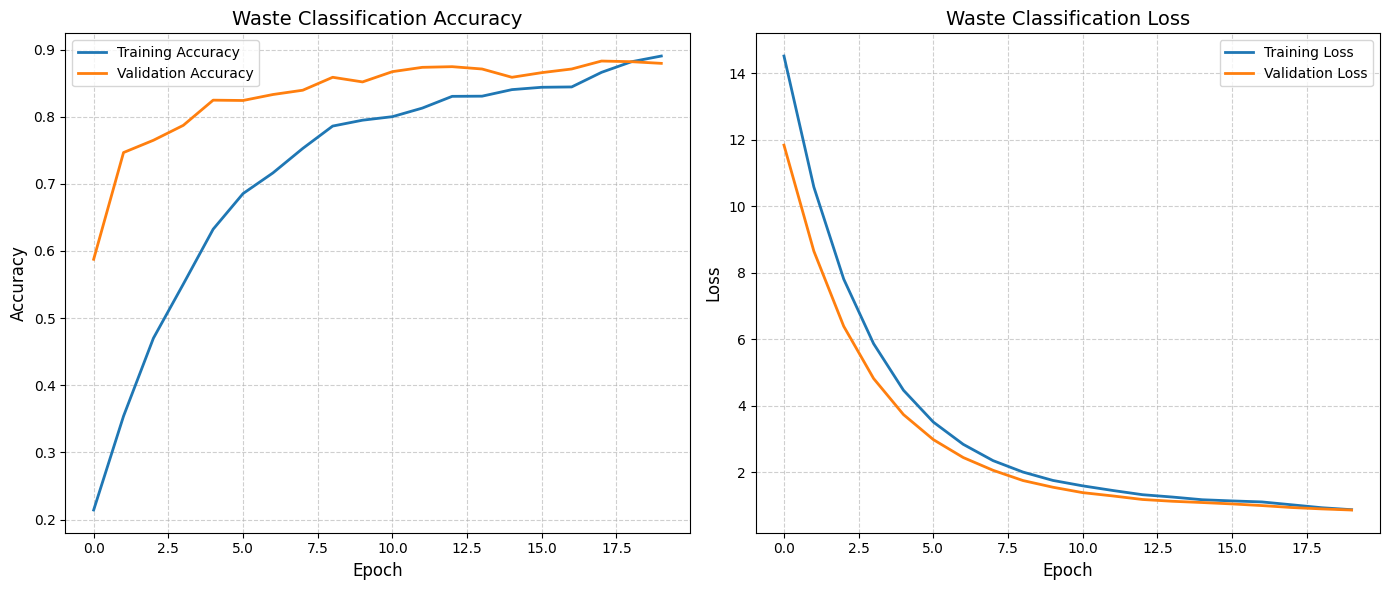

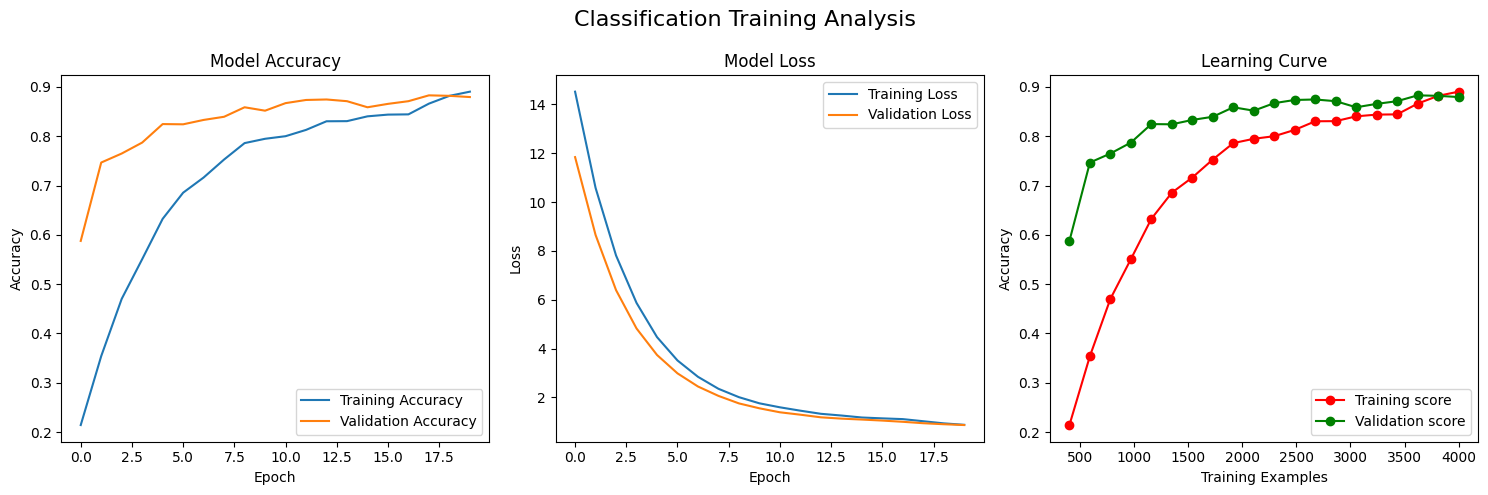

In [19]:
history = classifier.train(
    X_train=X_train_processed,
    y_train=train_labels,
    X_val=X_val_processed,
    y_val=val_labels,
    batch_size=64,
    epochs=30,
    patience=8,
    class_weights=class_weights,
    max_samples=max_samples
)

classifier.plot_training_history(history)

plt.figure(figsize=(15, 5))
plt.suptitle("Classification Training Analysis", fontsize=16)

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)

epochs = list(range(1, len(history.history['accuracy']) + 1))
train_sizes = np.linspace(0.1, 1.0, len(epochs)) * max_samples
plt.plot(train_sizes, history.history['accuracy'], 'o-', color='r', label="Training score")
plt.plot(train_sizes, history.history['val_accuracy'], 'o-', color='g', label="Validation score")
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend(loc="best")

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


[6] Evaluating model...
Prediction distribution:
  Class Clothes: 167 predictions (8.2%)
  Class Glass: 202 predictions (10.0%)
  Class Metal: 339 predictions (16.7%)
  Class Organic: 251 predictions (12.4%)
  Class Paper: 369 predictions (18.2%)
  Class Plastic: 697 predictions (34.4%)

===== Test Set Metrics =====
Accuracy: 0.8617
Precision: 0.8620
Recall: 0.8542
F1 Score: 0.8555

Classification Report:
              precision    recall  f1-score   support

     Clothes       0.77      0.85      0.81       150
       Glass       0.89      0.80      0.84       225
       Metal       0.80      0.90      0.85       300
     Organic       0.98      0.82      0.89       300
       Paper       0.89      0.87      0.88       375
     Plastic       0.85      0.88      0.86       675

    accuracy                           0.86      2025
   macro avg       0.86      0.85      0.86      2025
weighted avg       0.87      0.86      0.86      2025


Confusion Matrix:
[[128   0   0   0   9  13]
 

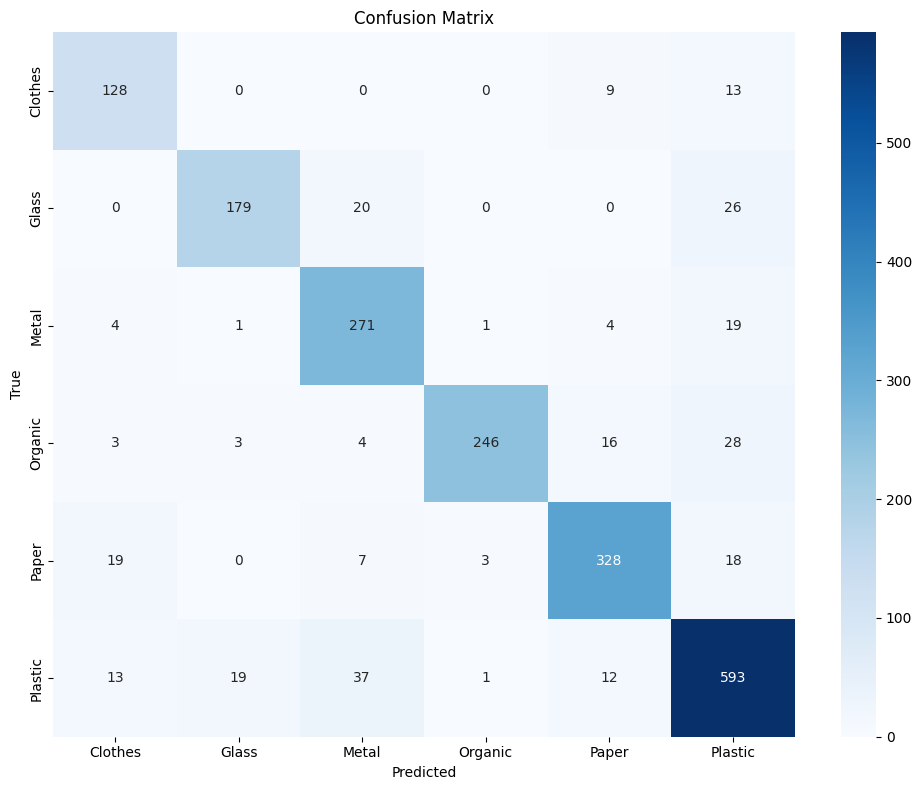

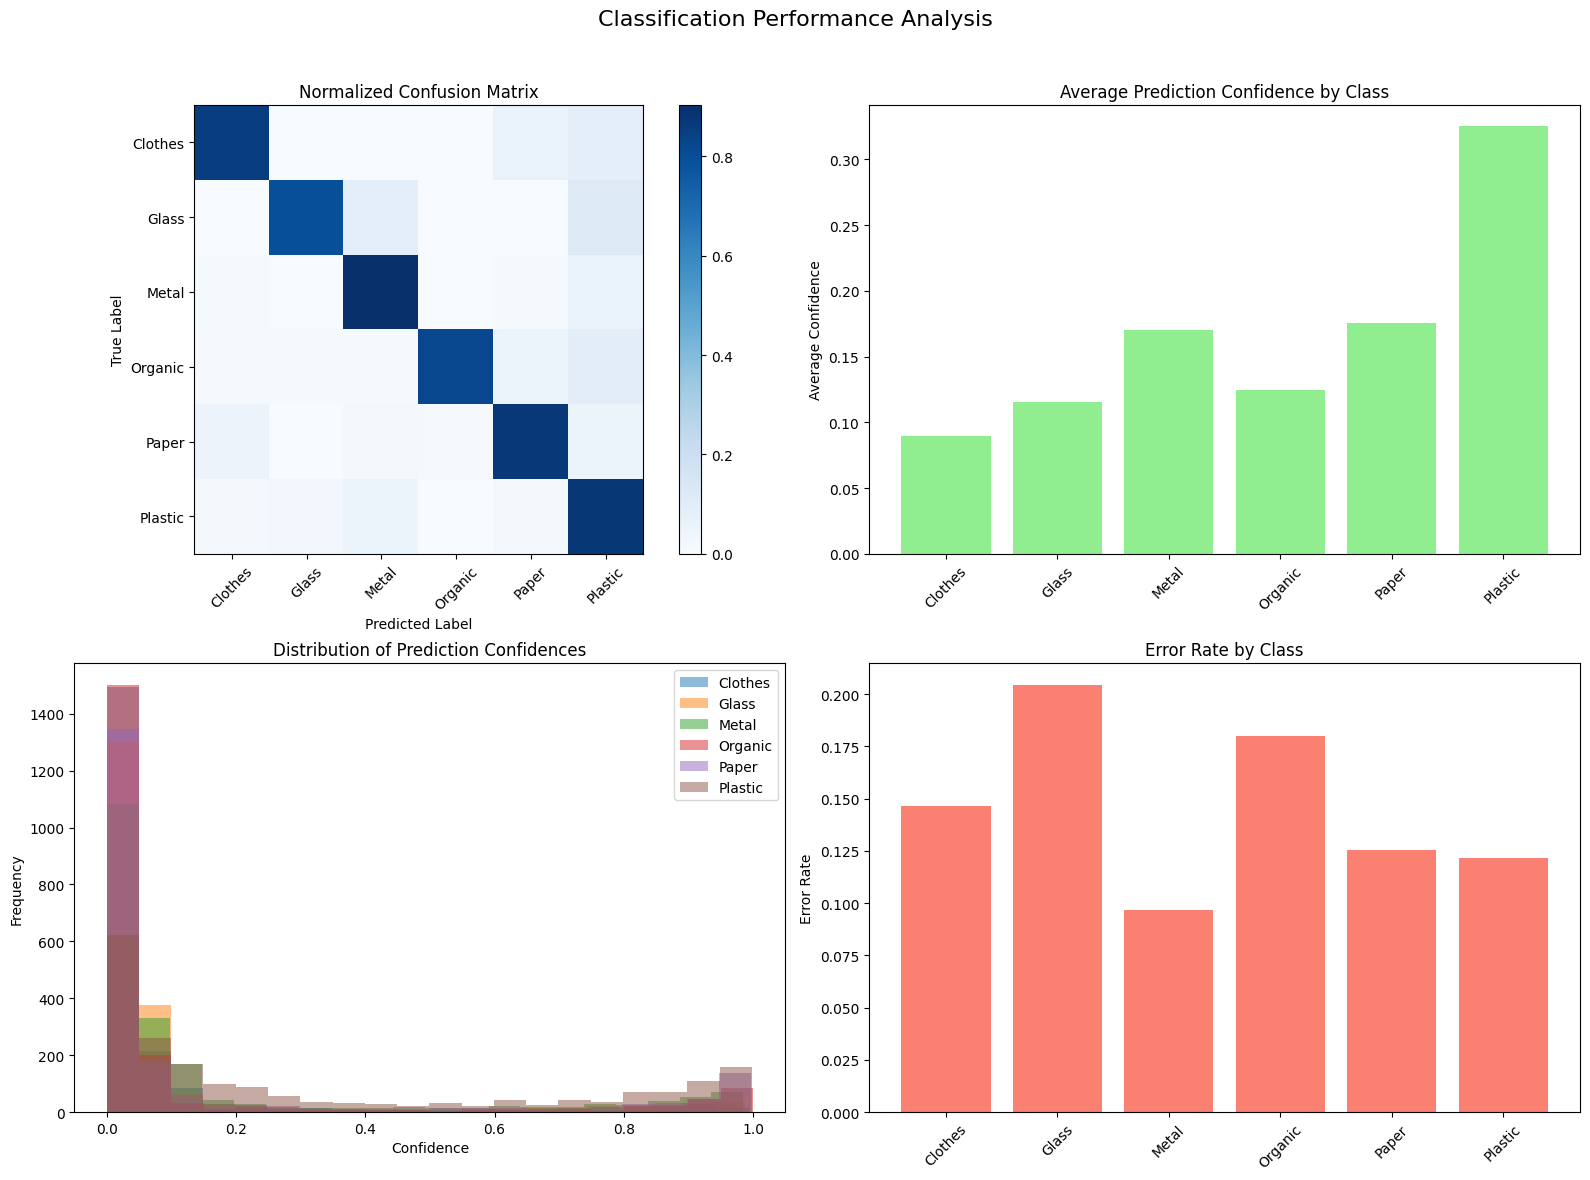

In [20]:
print("\n[6] Evaluating model...")
evaluator = ModelEvaluator(categories)

y_pred = classifier.predict(X_test_processed)

probabilities = classifier.model.predict(X_test_processed, verbose=0)

unique_preds, pred_counts = np.unique(y_pred, return_counts=True)
print(f"Prediction distribution:")
for pred_class in unique_preds:
    count = pred_counts[pred_class]
    print(f"  Class {categories[pred_class]}: {count} predictions ({count/len(y_pred)*100:.1f}%)")

evaluator.print_metrics(test_labels, y_pred, dataset_name="Test")

print("\nConfusion Matrix:")
cm = confusion_matrix(test_labels, y_pred)
print(cm)

try:
    evaluator.plot_confusion_matrix(test_labels, y_pred)
except Exception as e:
    print(f"Could not plot confusion matrix: {e}")

plt.figure(figsize=(16, 12))
plt.suptitle("Classification Performance Analysis", fontsize=16)

plt.subplot(2, 2, 1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 2, 2)
prediction_dist = {}
for i, cat in enumerate(categories):
    prediction_dist[cat] = sum(probabilities[:, i]) / len(probabilities)

plt.bar(prediction_dist.keys(), prediction_dist.values(), color='lightgreen')
plt.title('Average Prediction Confidence by Class')
plt.xticks(rotation=45)
plt.ylabel('Average Confidence')

plt.subplot(2, 2, 3)
for i, cat in enumerate(categories):
    plt.hist(probabilities[:, i], alpha=0.5, bins=20, label=cat)
plt.title('Distribution of Prediction Confidences')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 4)

error_rates = []
for i in range(len(categories)):
    indices = np.where(test_labels == i)[0]
    if len(indices) > 0:
        error_rate = sum(y_pred[indices] != i) / len(indices)
        error_rates.append(error_rate)
    else:
        error_rates.append(0)

plt.bar(categories, error_rates, color='salmon')
plt.title('Error Rate by Class')
plt.xticks(rotation=45)
plt.ylabel('Error Rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


[7] Class-specific analysis...

Detailed metrics by class:
  Clothes:
    Precision: 0.7665
    Recall: 0.8533
    F1-score: 0.8076
    Support: 150.0 samples
  Glass:
    Precision: 0.8861
    Recall: 0.7956
    F1-score: 0.8384
    Support: 225.0 samples
  Metal:
    Precision: 0.7994
    Recall: 0.9033
    F1-score: 0.8482
    Support: 300.0 samples
  Organic:
    Precision: 0.9801
    Recall: 0.8200
    F1-score: 0.8929
    Support: 300.0 samples
  Paper:
    Precision: 0.8889
    Recall: 0.8747
    F1-score: 0.8817
    Support: 375.0 samples
  Plastic:
    Precision: 0.8508
    Recall: 0.8785
    F1-score: 0.8644
    Support: 675.0 samples


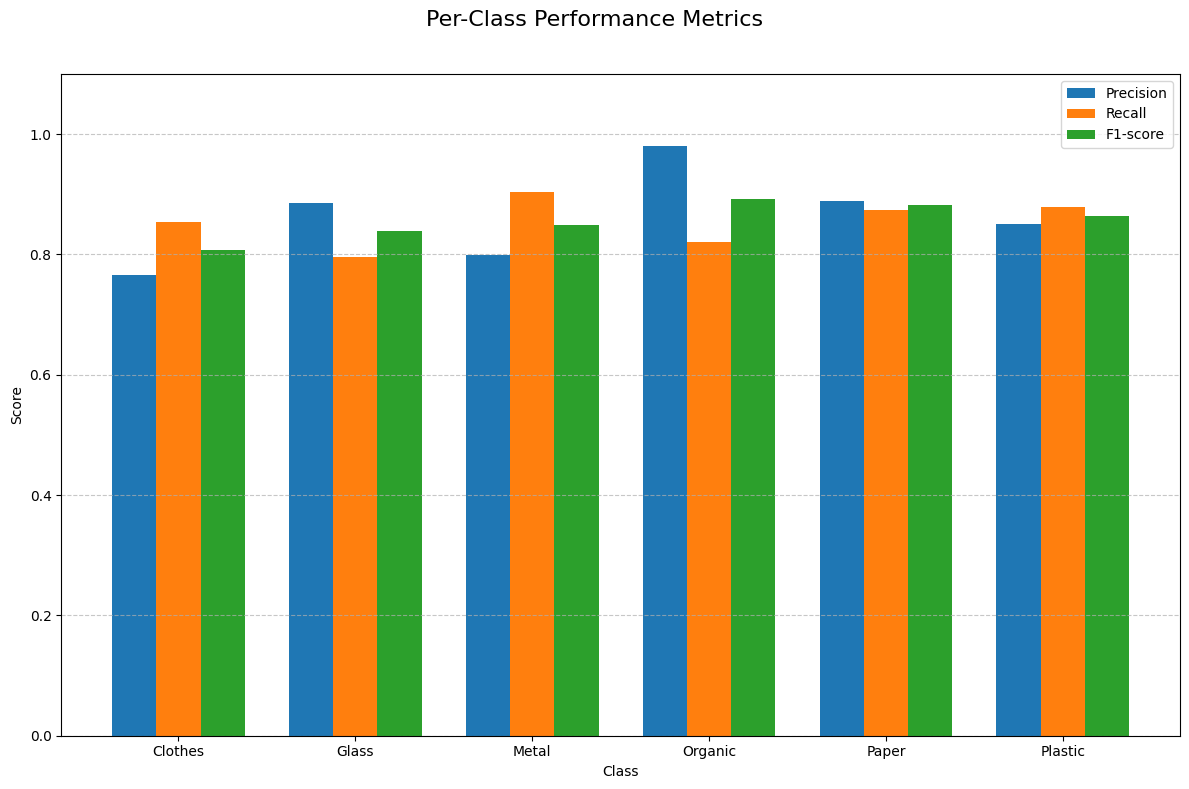

In [21]:
print("\n[7] Class-specific analysis...")

class_report = classification_report(test_labels, y_pred, target_names=categories, output_dict=True)

print("\nDetailed metrics by class:")
for material in categories:
    metrics = class_report[material]
    print(f"  {material.capitalize()}:")
    print(f"    Precision: {metrics['precision']:.4f}")
    print(f"    Recall: {metrics['recall']:.4f}")
    print(f"    F1-score: {metrics['f1-score']:.4f}")
    print(f"    Support: {metrics['support']} samples")

plt.figure(figsize=(12, 8))
plt.suptitle("Per-Class Performance Metrics", fontsize=16)

metrics = ['precision', 'recall', 'f1-score']
x = np.arange(len(categories))
width = 0.25

for i, metric in enumerate(metrics):
    values = [class_report[cat][metric] for cat in categories]
    plt.bar(x + i*width, values, width, label=metric.capitalize())

plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(x + width, categories)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


[8] Analyzing most confidently classified examples...
Most confidently classified examples:
  Image 1605: True=Organic, Predicted=Organic, Confidence=99.8%
  Image 907: True=Plastic, Predicted=Plastic, Confidence=99.8%
  Image 347: True=Organic, Predicted=Organic, Confidence=99.9%
  Image 1719: True=Organic, Predicted=Organic, Confidence=99.9%
  Image 895: True=Organic, Predicted=Organic, Confidence=100.0%


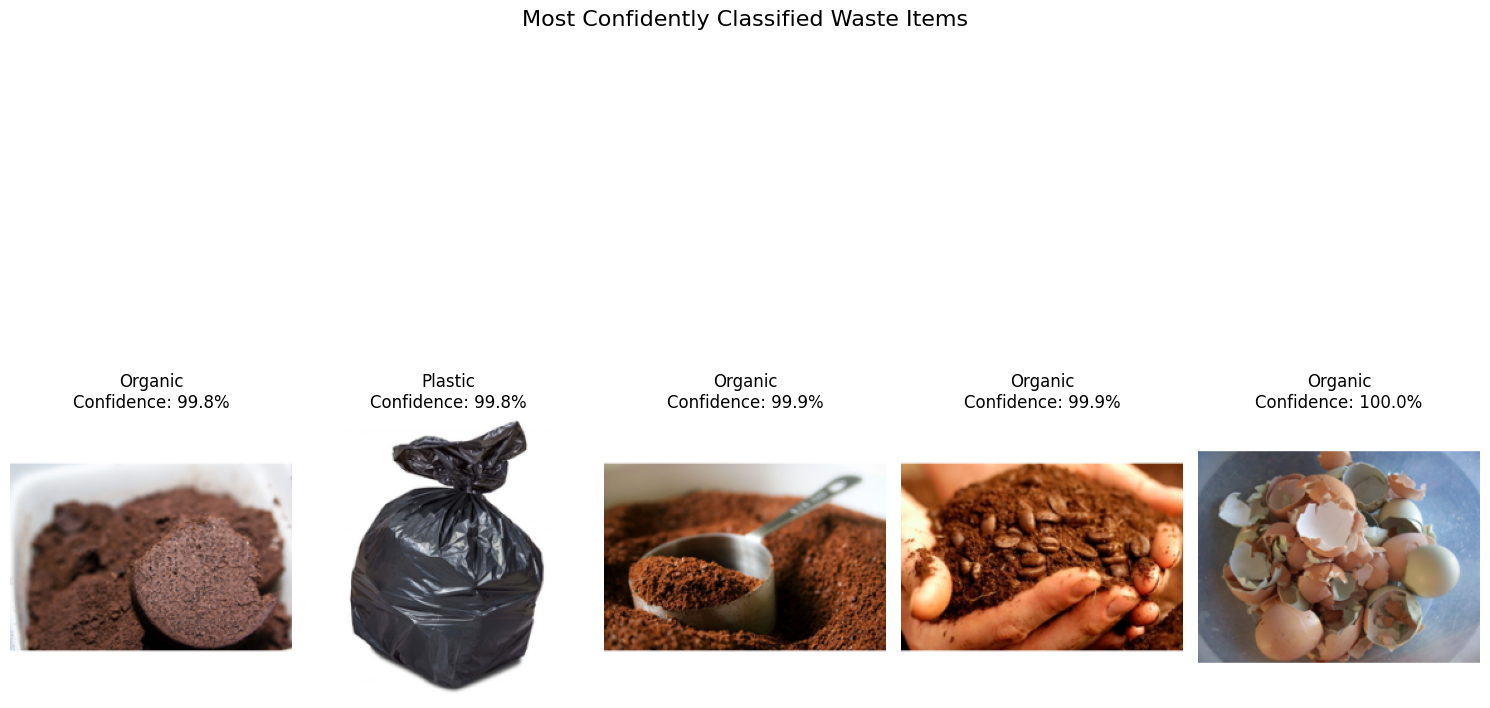

In [22]:
print("\n[8] Analyzing most confidently classified examples...")

correct_indices = np.where(y_pred == test_labels)[0]

num_examples = min(5, len(correct_indices))

if len(correct_indices) > 0:
    confidences = np.max(probabilities[correct_indices], axis=1)
    most_confident_correct = correct_indices[np.argsort(confidences)[-num_examples:]]
    
    print("Most confidently classified examples:")
    test_samples = []
    for idx in most_confident_correct:
        img = cv2.imread(test_data[idx])
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_samples.append(img)
        
        true_label = categories[test_labels[idx]]
        pred_label = categories[y_pred[idx]]
        confidence = np.max(probabilities[idx]) * 100
        print(f"  Image {idx}: True={true_label}, Predicted={pred_label}, Confidence={confidence:.1f}%")
    
    plt.figure(figsize=(15, 10))
    plt.suptitle("Most Confidently Classified Waste Items", fontsize=16)
    
    for i, img in enumerate(test_samples):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(img)
        true_label = categories[test_labels[most_confident_correct[i]]]
        conf = np.max(probabilities[most_confident_correct[i]]) * 100
        plt.title(f"{true_label}\nConfidence: {conf:.1f}%")
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [23]:
print("\n[9] Saving model...")
save_model(classifier.model, "waste_classifier_model.h5")
print("Model saved to waste_classifier_model.h5")

print("\nWaste Classification Pipeline completed successfully!")


[9] Saving model...
Model saved to waste_classifier_model.h5
Model saved to waste_classifier_model.h5

Waste Classification Pipeline completed successfully!


Glass (real_world): Image_24.png
Metal (real_world): Image_224_3.png
Paper (real_world): Image_79_4.png
Plastic (default): Image_192.png
Clothes (real_world): Image_207_1.png
Organic (default): Image_116_3.png


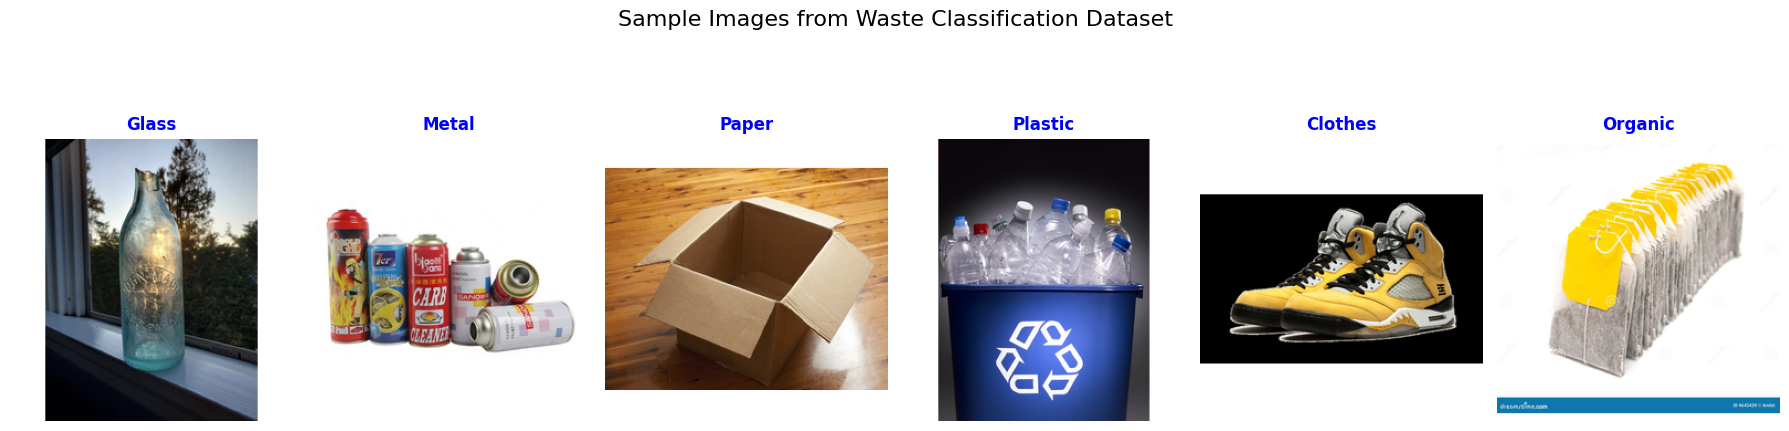

In [31]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

dataset_dir = '/home/x/Desktop/dataset'

categories = ['Glass', 'Metal', 'Paper', 'Plastic', 'Clothes', 'Organic']
main_categories = ['Glass', 'Metal', 'Paper', 'Plastic', 'Clothes', 'Organic']

def get_random_image(category):
    category_path = os.path.join(dataset_dir, 'classes', category)
    
    if not os.path.exists(category_path):
        print(f"Category path not found: {category_path}")
        return None
    
    subfolders = ['default', 'real_world']
    selected_folder = random.choice(subfolders)
    folder_path = os.path.join(category_path, selected_folder)
    
    if not os.path.exists(folder_path):
        print(f"Subfolder not found: {folder_path}")
        return None
    
    try:
        all_images = [file for file in os.listdir(folder_path) 
                      if file.lower().endswith(('.png', '.jpg', '.jpeg')) 
                      and os.path.isfile(os.path.join(folder_path, file))]
        
        if not all_images:
            print(f"No images found in {folder_path}")
            return None
        
        random_image = random.choice(all_images)
        img_path = os.path.join(folder_path, random_image)
        
        print(f"{category} ({selected_folder}): {random_image}")
        
        return img_path
    except Exception as e:
        print(f"Error accessing {folder_path}: {e}")
        return None

fig, axes = plt.subplots(1, len(categories), figsize=(18, 5))

for i, category in enumerate(categories):
    img_path = get_random_image(category)
    
    if img_path:
        try:
            img = Image.open(img_path)
            
            if img.mode == 'RGBA':
                img = img.convert('RGB')
                
            axes[i].imshow(img)
            
            title_color = 'black'
            if category in main_categories:
                title_color = 'blue'
                for spine in axes[i].spines.values():
                    spine.set_edgecolor('blue')
                    spine.set_linewidth(3)
            
            axes[i].set_title(category, color=title_color, fontweight='bold' if category in main_categories else 'normal')
        except Exception as e:
            print(f"Error displaying {img_path}: {e}")
            axes[i].text(0.5, 0.5, f"Error: {str(e)[:20]}...", 
                         ha='center', va='center', transform=axes[i].transAxes)
    else:
        axes[i].text(0.5, 0.5, f"No image found\nfor {category}", 
                     ha='center', va='center', transform=axes[i].transAxes)
    
    axes[i].axis('off')

plt.suptitle("Sample Images from Waste Classification Dataset", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [32]:
import os
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from feature_extraction import FeatureExtractor

os.makedirs("exported_models", exist_ok=True)

feature_extractor = FeatureExtractor(input_shape=(224, 224, 3))
base_model = feature_extractor.model

base_model.save("exported_models/feature_extractor_base_model.h5")
print("Saved feature extractor base model to exported_models/feature_extractor_base_model.h5")

print("Generating sample features to calibrate the scaler...")
sample_features = []

for _ in range(20):
    dummy_img = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
    
    try:
        features = feature_extractor.extract_features(dummy_img)
        features = np.nan_to_num(features)  # Replace NaN values
        sample_features.append(features)
    except Exception as e:
        print(f"Error extracting features: {e}")

if sample_features:
    sample_features = np.array(sample_features)
    print(f"Generated {len(sample_features)} sample feature vectors with shape {sample_features.shape}")
    
    scaler = StandardScaler()
    scaler.fit(sample_features)
    
    with open("exported_models/feature_scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
    print("Saved feature scaler to exported_models/feature_scaler.pkl")

feature_config = {
    "input_shape": (224, 224, 3),
    "feature_dimensions": sample_features.shape[1] if len(sample_features) > 0 else None,
    "use_deep_features": True,
    "use_color_features": True,
    "use_texture_features": True,
    "use_material_features": True
}

with open("exported_models/feature_config.pkl", "wb") as f:
    pickle.dump(feature_config, f)
print("Saved feature extraction configuration to exported_models/feature_config.pkl")

print("\nExported all components needed for the GUI to accurately replicate the feature extraction pipeline!")

Feature extractor initialized with output shape: (None, 1280)
Saved feature extractor base model to exported_models/feature_extractor_base_model.h5
Generating sample features to calibrate the scaler...
Generated 20 sample feature vectors with shape (20, 1598)
Saved feature scaler to exported_models/feature_scaler.pkl
Saved feature extraction configuration to exported_models/feature_config.pkl

Exported all components needed for the GUI to accurately replicate the feature extraction pipeline!


In [39]:
!python3 gui.py

2025-05-06 02:24:48.103843: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 02:24:48.120276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746498288.145754  512626 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746498288.152155  512626 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746498288.167961  512626 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 